# Homework3 & Homework4
- Task06：批量归一化和残差网络；凸优化；梯度下降；优化算法进阶
- Task07：目标检测基础；图像风格迁移；图像分类案例1
- Task08：图像分类案例2；GAN；DCGAN

# Task06：批量归一化和残差网络；凸优化；梯度下降；优化算法进阶
- 批量归一化和残差网络
- 凸优化
- 梯度下降
- 优化算法进阶

# 批量归一化和残差网络
- Batch Normalization(BN)
- ResNet
- DenseNet

## 批量归一化（Batch Normalization）
#### 对输入的标准化（浅层模型）
处理后的任意一个特征在数据集中所有样本上的均值为0、标准差为1。  
标准化处理输入数据使各个特征的分布相近
#### 批量归一化（深度模型）
利用小批量上的均值和标准差，不断调整神经网络中间输出，从而使整个神经网络在各层的中间输出的数值更稳定。

### 1.对全连接层做批量归一化
位置：全连接层中的仿射变换和激活函数之间。  
**全连接：**  
$$
\boldsymbol{x} = \boldsymbol{W\boldsymbol{u} + \boldsymbol{b}} \\
 output =\phi(\boldsymbol{x})
 $$   


**批量归一化：**
$$ 
output=\phi(\text{BN}(\boldsymbol{x}))$$


$$
\boldsymbol{y}^{(i)} = \text{BN}(\boldsymbol{x}^{(i)})
$$


$$
\boldsymbol{\mu}_\mathcal{B} \leftarrow \frac{1}{m}\sum_{i = 1}^{m} \boldsymbol{x}^{(i)},
$$ 
$$
\boldsymbol{\sigma}_\mathcal{B}^2 \leftarrow \frac{1}{m} \sum_{i=1}^{m}(\boldsymbol{x}^{(i)} - \boldsymbol{\mu}_\mathcal{B})^2,
$$


$$
\hat{\boldsymbol{x}}^{(i)} \leftarrow \frac{\boldsymbol{x}^{(i)} - \boldsymbol{\mu}_\mathcal{B}}{\sqrt{\boldsymbol{\sigma}_\mathcal{B}^2 + \epsilon}},
$$

这里ϵ > 0是个很小的常数，保证分母大于0


$$
{\boldsymbol{y}}^{(i)} \leftarrow \boldsymbol{\gamma} \odot
\hat{\boldsymbol{x}}^{(i)} + \boldsymbol{\beta}.
$$


引入可学习参数：拉伸参数γ和偏移参数β。若$\boldsymbol{\gamma} = \sqrt{\boldsymbol{\sigma}_\mathcal{B}^2 + \epsilon}$和$\boldsymbol{\beta} = \boldsymbol{\mu}_\mathcal{B}$，批量归一化无效。

### 2.对卷积层做批量归一化
位置：卷积计算之后、应在激活函数之前。  
如果卷积计算输出多个通道，我们需要对这些通道的输出分别做批量归一化，且每个通道都拥有独立的拉伸和偏移参数。
计算：对单通道，batchsize=m,卷积计算输出=pxq
对该通道中m×p×q个元素同时做批量归一化,使用相同的均值和方差。

### 3.预测时的批量归一化
训练：以batch为单位,对每个batch计算均值和方差。  
预测：用移动平均估算整个训练数据集的样本均值和方差。
### 从零实现

In [2]:
#考虑到本代码中的模型过大，CPU训练较慢，
#我们还将代码上传了一份到 https://www.kaggle.com/boyuai/boyu-d2l-deepcnn
#如希望提前使用gpu运行请至kaggle。

In [1]:
import time
import torch
from torch import nn, optim
import torch.nn.functional as F
import torchvision
import sys
sys.path.append("/home/kesci/input/") 
import d2lzh1981 as d2l
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def batch_norm(is_training, X, gamma, beta, moving_mean, moving_var, eps, momentum):
    # 判断当前模式是训练模式还是预测模式
    if not is_training:
        # 如果是在预测模式下，直接使用传入的移动平均所得的均值和方差
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
    else:
        assert len(X.shape) in (2, 4)
        if len(X.shape) == 2:
            # 使用全连接层的情况，计算特征维上的均值和方差
            mean = X.mean(dim=0)
            var = ((X - mean) ** 2).mean(dim=0)
        else:
            # 使用二维卷积层的情况，计算通道维上（axis=1）的均值和方差。这里我们需要保持
            # X的形状以便后面可以做广播运算
            mean = X.mean(dim=0, keepdim=True).mean(dim=2, keepdim=True).mean(dim=3, keepdim=True)
            var = ((X - mean) ** 2).mean(dim=0, keepdim=True).mean(dim=2, keepdim=True).mean(dim=3, keepdim=True)
        # 训练模式下用当前的均值和方差做标准化
        X_hat = (X - mean) / torch.sqrt(var + eps)
        # 更新移动平均的均值和方差
        moving_mean = momentum * moving_mean + (1.0 - momentum) * mean
        moving_var = momentum * moving_var + (1.0 - momentum) * var
    Y = gamma * X_hat + beta  # 拉伸和偏移
    return Y, moving_mean, moving_var

In [3]:
class BatchNorm(nn.Module):
    def __init__(self, num_features, num_dims):
        super(BatchNorm, self).__init__()
        if num_dims == 2:
            shape = (1, num_features) #全连接层输出神经元
        else:
            shape = (1, num_features, 1, 1)  #通道数
        # 参与求梯度和迭代的拉伸和偏移参数，分别初始化成0和1
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        # 不参与求梯度和迭代的变量，全在内存上初始化成0
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.zeros(shape)

    def forward(self, X):
        # 如果X不在内存上，将moving_mean和moving_var复制到X所在显存上
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        # 保存更新过的moving_mean和moving_var, Module实例的traning属性默认为true, 调用.eval()后设成false
        Y, self.moving_mean, self.moving_var = batch_norm(self.training, 
            X, self.gamma, self.beta, self.moving_mean,
            self.moving_var, eps=1e-5, momentum=0.9)
        return Y

### 基于LeNet的应用

In [4]:
net = nn.Sequential(
            nn.Conv2d(1, 6, 5), # in_channels, out_channels, kernel_size
            BatchNorm(6, num_dims=4),
            nn.Sigmoid(),
            nn.MaxPool2d(2, 2), # kernel_size, stride
            nn.Conv2d(6, 16, 5),
            BatchNorm(16, num_dims=4),
            nn.Sigmoid(),
            nn.MaxPool2d(2, 2),
            d2l.FlattenLayer(),
            nn.Linear(16*4*4, 120),
            BatchNorm(120, num_dims=2),
            nn.Sigmoid(),
            nn.Linear(120, 84),
            BatchNorm(84, num_dims=2),
            nn.Sigmoid(),
            nn.Linear(84, 10)
        )
print(net)

Sequential(
  (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (1): BatchNorm()
  (2): Sigmoid()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (5): BatchNorm()
  (6): Sigmoid()
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): FlattenLayer()
  (9): Linear(in_features=256, out_features=120, bias=True)
  (10): BatchNorm()
  (11): Sigmoid()
  (12): Linear(in_features=120, out_features=84, bias=True)
  (13): BatchNorm()
  (14): Sigmoid()
  (15): Linear(in_features=84, out_features=10, bias=True)
)


In [5]:
#batch_size = 256  
##cpu要调小batchsize
batch_size=16

def load_data_fashion_mnist(batch_size, resize=None, root='/home/kesci/input/FashionMNIST2065'):
    """Download the fashion mnist dataset and then load into memory."""
    trans = []
    if resize:
        trans.append(torchvision.transforms.Resize(size=resize))
    trans.append(torchvision.transforms.ToTensor())
    
    transform = torchvision.transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(root=root, train=True, download=True, transform=transform)
    mnist_test = torchvision.datasets.FashionMNIST(root=root, train=False, download=True, transform=transform)

    train_iter = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=2)
    test_iter = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=2)

    return train_iter, test_iter
train_iter, test_iter = load_data_fashion_mnist(batch_size)

In [10]:
lr, num_epochs = 0.001, 5
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
d2l.train_ch5(net, train_iter, test_iter, batch_size, optimizer, device, num_epochs)

### 简洁实现

In [ ]:
net = nn.Sequential(
            nn.Conv2d(1, 6, 5), # in_channels, out_channels, kernel_size
            nn.BatchNorm2d(6),
            nn.Sigmoid(),
            nn.MaxPool2d(2, 2), # kernel_size, stride
            nn.Conv2d(6, 16, 5),
            nn.BatchNorm2d(16),
            nn.Sigmoid(),
            nn.MaxPool2d(2, 2),
            d2l.FlattenLayer(),
            nn.Linear(16*4*4, 120),
            nn.BatchNorm1d(120),
            nn.Sigmoid(),
            nn.Linear(120, 84),
            nn.BatchNorm1d(84),
            nn.Sigmoid(),
            nn.Linear(84, 10)
        )

optimizer = torch.optim.Adam(net.parameters(), lr=lr)
d2l.train_ch5(net, train_iter, test_iter, batch_size, optimizer, device, num_epochs)

## 残差网络（ResNet）
深度学习的问题：深度CNN网络达到一定深度后再一味地增加层数并不能带来进一步地分类性能提高，反而会招致网络收敛变得更慢，准确率也变得更差。
### 残差块（Residual Block）
恒等映射：  
左边：f(x)=x                                                  
右边：f(x)-x=0 （易于捕捉恒等映射的细微波动）

![Image Name](https://cdn.kesci.com/upload/image/q5l8lhnot4.png?imageView2/0/w/600/h/600)

在残差块中，输⼊可通过跨层的数据线路更快 地向前传播。
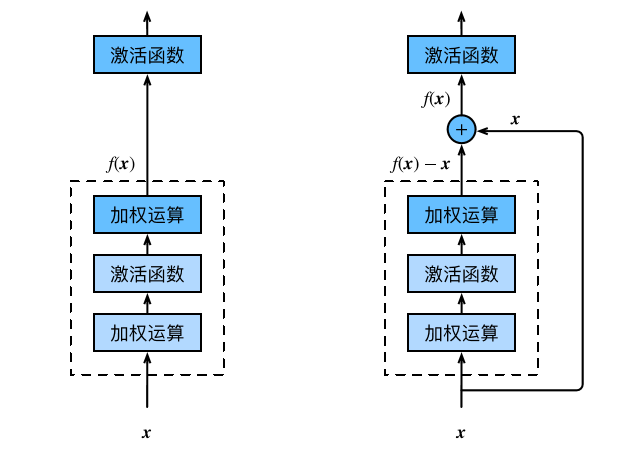

In [6]:
class Residual(nn.Module):  # 本类已保存在d2lzh_pytorch包中方便以后使用
    #可以设定输出通道数、是否使用额外的1x1卷积层来修改通道数以及卷积层的步幅。
    def __init__(self, in_channels, out_channels, use_1x1conv=False, stride=1):
        super(Residual, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        return F.relu(Y + X)

In [7]:
blk = Residual(3, 3)
X = torch.rand((4, 3, 6, 6))
blk(X).shape # torch.Size([4, 3, 6, 6])

torch.Size([4, 3, 6, 6])

In [8]:
blk = Residual(3, 6, use_1x1conv=True, stride=2)
blk(X).shape # torch.Size([4, 6, 3, 3])

torch.Size([4, 6, 3, 3])

### ResNet模型
卷积(64,7x7,3)  
批量一体化  
最大池化(3x3,2)  

残差块x4 (通过步幅为2的残差块在每个模块之间减小高和宽)

全局平均池化

全连接

In [9]:
net = nn.Sequential(
        nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
        nn.BatchNorm2d(64), 
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [10]:
def resnet_block(in_channels, out_channels, num_residuals, first_block=False):
    if first_block:
        assert in_channels == out_channels # 第一个模块的通道数同输入通道数一致
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(in_channels, out_channels, use_1x1conv=True, stride=2))
        else:
            blk.append(Residual(out_channels, out_channels))
    return nn.Sequential(*blk)

net.add_module("resnet_block1", resnet_block(64, 64, 2, first_block=True))
net.add_module("resnet_block2", resnet_block(64, 128, 2))
net.add_module("resnet_block3", resnet_block(128, 256, 2))
net.add_module("resnet_block4", resnet_block(256, 512, 2))

In [11]:
net.add_module("global_avg_pool", d2l.GlobalAvgPool2d()) # GlobalAvgPool2d的输出: (Batch, 512, 1, 1)
net.add_module("fc", nn.Sequential(d2l.FlattenLayer(), nn.Linear(512, 10))) 

In [12]:
X = torch.rand((1, 1, 224, 224))
for name, layer in net.named_children():
    X = layer(X)
    print(name, ' output shape:\t', X.shape)

0  output shape:	 torch.Size([1, 64, 112, 112])
1  output shape:	 torch.Size([1, 64, 112, 112])
2  output shape:	 torch.Size([1, 64, 112, 112])
3  output shape:	 torch.Size([1, 64, 56, 56])
resnet_block1  output shape:	 torch.Size([1, 64, 56, 56])
resnet_block2  output shape:	 torch.Size([1, 128, 28, 28])
resnet_block3  output shape:	 torch.Size([1, 256, 14, 14])
resnet_block4  output shape:	 torch.Size([1, 512, 7, 7])
global_avg_pool  output shape:	 torch.Size([1, 512, 1, 1])
fc  output shape:	 torch.Size([1, 10])


In [13]:
lr, num_epochs = 0.001, 5
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
d2l.train_ch5(net, train_iter, test_iter, batch_size, optimizer, device, num_epochs)

## 稠密连接网络（DenseNet）

![Image Name](https://cdn.kesci.com/upload/image/q5l8mi78yz.png?imageView2/0/w/600/h/600)

###主要构建模块：  
稠密块（dense block）： 定义了输入和输出是如何连结的。  
过渡层（transition layer）：用来控制通道数，使之不过大。
### 稠密块
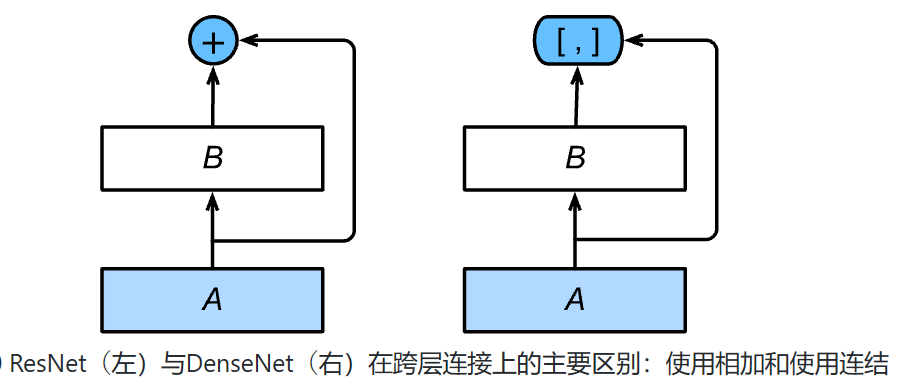

In [13]:
def conv_block(in_channels, out_channels):
    blk = nn.Sequential(nn.BatchNorm2d(in_channels), 
                        nn.ReLU(),
                        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
    return blk

class DenseBlock(nn.Module):
    def __init__(self, num_convs, in_channels, out_channels):
        super(DenseBlock, self).__init__()
        net = []
        for i in range(num_convs):
            in_c = in_channels + i * out_channels
            net.append(conv_block(in_c, out_channels))
        self.net = nn.ModuleList(net)
        self.out_channels = in_channels + num_convs * out_channels # 计算输出通道数

    def forward(self, X):
        for blk in self.net:
            Y = blk(X)
            X = torch.cat((X, Y), dim=1)  # 在通道维上将输入和输出连结
        return X

In [14]:
blk = DenseBlock(2, 3, 10)
X = torch.rand(4, 3, 8, 8)
Y = blk(X)
Y.shape # torch.Size([4, 23, 8, 8])

torch.Size([4, 23, 8, 8])

### 过渡层
$1\times1$卷积层：来减小通道数  
步幅为2的平均池化层：减半高和宽

In [15]:
def transition_block(in_channels, out_channels):
    blk = nn.Sequential(
            nn.BatchNorm2d(in_channels), 
            nn.ReLU(),
            nn.Conv2d(in_channels, out_channels, kernel_size=1),
            nn.AvgPool2d(kernel_size=2, stride=2))
    return blk

blk = transition_block(23, 10)
blk(Y).shape # torch.Size([4, 10, 4, 4])

torch.Size([4, 10, 4, 4])

### DenseNet模型

In [16]:
net = nn.Sequential(
        nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
        nn.BatchNorm2d(64), 
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [17]:
num_channels, growth_rate = 64, 32  # num_channels为当前的通道数
num_convs_in_dense_blocks = [4, 4, 4, 4]

for i, num_convs in enumerate(num_convs_in_dense_blocks):
    DB = DenseBlock(num_convs, num_channels, growth_rate)
    net.add_module("DenseBlosk_%d" % i, DB)
    # 上一个稠密块的输出通道数
    num_channels = DB.out_channels
    # 在稠密块之间加入通道数减半的过渡层
    if i != len(num_convs_in_dense_blocks) - 1:
        net.add_module("transition_block_%d" % i, transition_block(num_channels, num_channels // 2))
        num_channels = num_channels // 2

In [18]:
net.add_module("BN", nn.BatchNorm2d(num_channels))
net.add_module("relu", nn.ReLU())
net.add_module("global_avg_pool", d2l.GlobalAvgPool2d()) # GlobalAvgPool2d的输出: (Batch, num_channels, 1, 1)
net.add_module("fc", nn.Sequential(d2l.FlattenLayer(), nn.Linear(num_channels, 10))) 

X = torch.rand((1, 1, 96, 96))
for name, layer in net.named_children():
    X = layer(X)
    print(name, ' output shape:\t', X.shape)

0  output shape:	 torch.Size([1, 64, 48, 48])
1  output shape:	 torch.Size([1, 64, 48, 48])
2  output shape:	 torch.Size([1, 64, 48, 48])
3  output shape:	 torch.Size([1, 64, 24, 24])
DenseBlosk_0  output shape:	 torch.Size([1, 192, 24, 24])
transition_block_0  output shape:	 torch.Size([1, 96, 12, 12])
DenseBlosk_1  output shape:	 torch.Size([1, 224, 12, 12])
transition_block_1  output shape:	 torch.Size([1, 112, 6, 6])
DenseBlosk_2  output shape:	 torch.Size([1, 240, 6, 6])
transition_block_2  output shape:	 torch.Size([1, 120, 3, 3])
DenseBlosk_3  output shape:	 torch.Size([1, 248, 3, 3])
BN  output shape:	 torch.Size([1, 248, 3, 3])
relu  output shape:	 torch.Size([1, 248, 3, 3])
global_avg_pool  output shape:	 torch.Size([1, 248, 1, 1])
fc  output shape:	 torch.Size([1, 10])


In [20]:
#batch_size = 256
batch_size=16
# 如出现“out of memory”的报错信息，可减小batch_size或resize
train_iter, test_iter =load_data_fashion_mnist(batch_size, resize=96)
lr, num_epochs = 0.001, 5
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
d2l.train_ch5(net, train_iter, test_iter, batch_size, optimizer, device, num_epochs)

# 凸优化
> 深度学习中的优化问题和凸性介绍
- 优化与深度学习
- 凸性

# 优化与深度学习
**优化与估计**

尽管优化方法可以最小化深度学习中的损失函数值，但本质上优化方法达到的目标与深度学习的目标并不相同。
- 优化方法目标：训练集损失函数值
- 深度学习目标：测试集损失函数值（泛化性）

In [ ]:
%matplotlib inline
import sys
sys.path.append('/home/kesci/input')
import d2lzh1981 as d2l
from mpl_toolkits import mplot3d # 三维画图
import numpy as np

In [ ]:
def f(x): return x * np.cos(np.pi * x)
def g(x): return f(x) + 0.2 * np.cos(5 * np.pi * x)

d2l.set_figsize((5, 3))
x = np.arange(0.5, 1.5, 0.01)
fig_f, = d2l.plt.plot(x, f(x),label="train error")
fig_g, = d2l.plt.plot(x, g(x),'--', c='purple', label="test error")
fig_f.axes.annotate('empirical risk', (1.0, -1.2), (0.5, -1.1),arrowprops=dict(arrowstyle='->'))
fig_g.axes.annotate('expected risk', (1.1, -1.05), (0.95, -0.5),arrowprops=dict(arrowstyle='->'))
d2l.plt.xlabel('x')
d2l.plt.ylabel('risk')
d2l.plt.legend(loc="upper right")

## 优化在深度学习中的挑战
1. 局部最小值
2. 鞍点
3. 梯度消失

### 局部最小值

$$
f(x) = x\cos \pi x
$$


In [ ]:
def f(x):
    return x * np.cos(np.pi * x)

d2l.set_figsize((4.5, 2.5))
x = np.arange(-1.0, 2.0, 0.1)
fig,  = d2l.plt.plot(x, f(x))
fig.axes.annotate('local minimum', xy=(-0.3, -0.25), xytext=(-0.77, -1.0),
                  arrowprops=dict(arrowstyle='->'))
fig.axes.annotate('global minimum', xy=(1.1, -0.95), xytext=(0.6, 0.8),
                  arrowprops=dict(arrowstyle='->'))
d2l.plt.xlabel('x')
d2l.plt.ylabel('f(x)');

### 鞍点

In [ ]:
x = np.arange(-2.0, 2.0, 0.1)
fig, = d2l.plt.plot(x, x**3)
fig.axes.annotate('saddle point', xy=(0, -0.2), xytext=(-0.52, -5.0),
                  arrowprops=dict(arrowstyle='->'))
d2l.plt.xlabel('x')
d2l.plt.ylabel('f(x)');

In [ ]:
x, y = np.mgrid[-1: 1: 31j, -1: 1: 31j]
z = x**2 - y**2

d2l.set_figsize((6, 4))
ax = d2l.plt.figure().add_subplot(111, projection='3d')
ax.plot_wireframe(x, y, z, **{'rstride': 2, 'cstride': 2})
ax.plot([0], [0], [0], 'ro', markersize=10)
ticks = [-1,  0, 1]
d2l.plt.xticks(ticks)
d2l.plt.yticks(ticks)
ax.set_zticks(ticks)
d2l.plt.xlabel('x')
d2l.plt.ylabel('y');

### 梯度消失

In [ ]:
x = np.arange(-2.0, 5.0, 0.01)
fig, = d2l.plt.plot(x, np.tanh(x))
d2l.plt.xlabel('x')
d2l.plt.ylabel('f(x)')
fig.axes.annotate('vanishing gradient', (4, 1), (2, 0.0) ,arrowprops=dict(arrowstyle='->'))

# 凸性 （Convexity）

## 基础
### 集合
![Image Name](https://cdn.kesci.com/upload/image/q5p1yhqzm8.png?imageView2/0/w/640/h/640)
![Image Name](https://cdn.kesci.com/upload/image/q5p1xz9gvz.png?imageView2/0/w/640/h/640)
![Image Name](https://cdn.kesci.com/upload/image/q5p1yue9fu.png?imageView2/0/w/320/h/320)

### 函数

In [ ]:
def f(x):
    return 0.5 * x**2  # Convex

def g(x):
    return np.cos(np.pi * x)  # Nonconvex

def h(x):
    return np.exp(0.5 * x)  # Convex

x, segment = np.arange(-2, 2, 0.01), np.array([-1.5, 1])
d2l.use_svg_display()
_, axes = d2l.plt.subplots(1, 3, figsize=(9, 3))

for ax, func in zip(axes, [f, g, h]):
    ax.plot(x, func(x))
    ax.plot(segment, func(segment),'--', color="purple")
    # d2l.plt.plot([x, segment], [func(x), func(segment)], axes=ax)

### Jensen 不等式

$$
\sum_{i} \alpha_{i} f\left(x_{i}\right) \geq f\left(\sum_{i} \alpha_{i} x_{i}\right) \text { and } E_{x}[f(x)] \geq f\left(E_{x}[x]\right)
$$


## 性质
1. 无局部极小值
2. 与凸集的关系
3. 二阶条件

###  无局部最小值
证明：假设存在 $x \in X$ 是局部最小值，则存在全局最小值 $x' \in X$, 使得 $f(x) > f(x')$, 则对 $\lambda \in(0,1]$:

$$
f(x)>\lambda f(x)+(1-\lambda) f(x^{\prime}) \geq f(\lambda x+(1-\lambda) x^{\prime})
$$


### 与凸集的关系
对于凸函数 $f(x)$，定义集合 $S_{b}:=\{x | x \in X \text { and } f(x) \leq b\}$，则集合 $S_b$ 为凸集

证明：对于点 $x,x' \in S_b$, 有 $f\left(\lambda x+(1-\lambda) x^{\prime}\right) \leq \lambda f(x)+(1-\lambda) f\left(x^{\prime}\right) \leq b$, 故 $\lambda x+(1-\lambda) x^{\prime} \in S_{b}$

$f(x, y)=0.5 x^{2}+\cos (2 \pi y)$

In [ ]:
x, y = np.meshgrid(np.linspace(-1, 1, 101), np.linspace(-1, 1, 101),
                   indexing='ij')

z = x**2 + 0.5 * np.cos(2 * np.pi * y)

# Plot the 3D surface
d2l.set_figsize((6, 4))
ax = d2l.plt.figure().add_subplot(111, projection='3d')
ax.plot_wireframe(x, y, z, **{'rstride': 10, 'cstride': 10})
ax.contour(x, y, z, offset=-1)
ax.set_zlim(-1, 1.5)

# Adjust labels
for func in [d2l.plt.xticks, d2l.plt.yticks, ax.set_zticks]:
    func([-1, 0, 1])

### 凸函数与二阶导数

$f^{''}(x) \ge 0 \Longleftrightarrow f(x)$ 是凸函数

**必要性 ($\Leftarrow$):**

对于凸函数：

$$
\frac{1}{2} f(x+\epsilon)+\frac{1}{2} f(x-\epsilon) \geq f\left(\frac{x+\epsilon}{2}+\frac{x-\epsilon}{2}\right)=f(x)
$$

故:

$$
f^{\prime \prime}(x)=\lim _{\varepsilon \rightarrow 0} \frac{\frac{f(x+\epsilon) - f(x)}{\epsilon}-\frac{f(x) - f(x-\epsilon)}{\epsilon}}{\epsilon}
$$


$$
f^{\prime \prime}(x)=\lim _{\varepsilon \rightarrow 0} \frac{f(x+\epsilon)+f(x-\epsilon)-2 f(x)}{\epsilon^{2}} \geq 0
$$


**充分性 ($\Rightarrow$):**

令 $a < x < b$ 为 $f(x)$ 上的三个点，由拉格朗日中值定理:

$$
\begin{array}{l}{f(x)-f(a)=(x-a) f^{\prime}(\alpha) \text { for some } \alpha \in[a, x] \text { and }} \\ {f(b)-f(x)=(b-x) f^{\prime}(\beta) \text { for some } \beta \in[x, b]}\end{array}
$$


根据单调性，有 $f^{\prime}(\beta) \geq f^{\prime}(\alpha)$, 故:

$$
\begin{aligned} f(b)-f(a) &=f(b)-f(x)+f(x)-f(a) \\ &=(b-x) f^{\prime}(\beta)+(x-a) f^{\prime}(\alpha) \\ & \geq(b-a) f^{\prime}(\alpha) \end{aligned}
$$

## 限制条件

### 拉格朗日乘子法
[Boyd & Vandenberghe, 2004](https://d2l.ai/chapter_references/zreferences.html#boyd-vandenberghe-2004)

### 惩罚项

欲使 $c_i(x) \leq 0$, 将项 $\alpha_ic_i(x)$ 加入目标函数，如多层感知机章节中的 $\frac{\lambda}{2} ||w||^2$

### 投影


$$
\operatorname{Proj}_{X}(\mathbf{x})=\underset{\mathbf{x}^{\prime} \in X}{\operatorname{argmin}}\left\|\mathbf{x}-\mathbf{x}^{\prime}\right\|_{2}
$$


![Image Name](https://cdn.kesci.com/upload/image/q5p241skoc.png?imageView2/0/w/640/h/640)

# 梯度下降 
（[Boyd & Vandenberghe, 2004](https://d2l.ai/chapter_references/zreferences.html#boyd-vandenberghe-2004)）
- 梯度下降
- 随机梯度下降
- 小批量梯度下降

In [ ]:
%matplotlib inline
import numpy as np
import torch
import time
from torch import nn, optim
import math
import sys
sys.path.append('/home/kesci/input')
import d2lzh1981 as d2l

## 一维梯度下降

**证明：沿梯度反方向移动自变量可以减小函数值**

泰勒展开：

$$
f(x+\epsilon)=f(x)+\epsilon f^{\prime}(x)+\mathcal{O}\left(\epsilon^{2}\right)
$$

代入沿梯度方向的移动量 $\eta f^{\prime}(x)$：

$$
f\left(x-\eta f^{\prime}(x)\right)=f(x)-\eta f^{\prime 2}(x)+\mathcal{O}\left(\eta^{2} f^{\prime 2}(x)\right)
$$

$$
f\left(x-\eta f^{\prime}(x)\right) \lesssim f(x)
$$


$$
x \leftarrow x-\eta f^{\prime}(x)
$$


In [ ]:
def f(x):
    return x**2  # Objective function

def gradf(x):
    return 2 * x  # Its derivative

def gd(eta):
    x = 10
    results = [x]
    for i in range(10):
        x -= eta * gradf(x)
        results.append(x)
    print('epoch 10, x:', x)
    return results

res = gd(0.2)

In [ ]:
def show_trace(res):
    n = max(abs(min(res)), abs(max(res)))
    f_line = np.arange(-n, n, 0.01)
    d2l.set_figsize((3.5, 2.5))
    d2l.plt.plot(f_line, [f(x) for x in f_line],'-')
    d2l.plt.plot(res, [f(x) for x in res],'-o')
    d2l.plt.xlabel('x')
    d2l.plt.ylabel('f(x)')
    

show_trace(res)

In [ ]:
# 学习率
show_trace(gd(0.05))

In [ ]:
show_trace(gd(1.1))

### 局部极小值

In [ ]:
c = 0.15 * np.pi

def f(x):
    return x * np.cos(c * x)

def gradf(x):
    return np.cos(c * x) - c * x * np.sin(c * x)

show_trace(gd(2))

## 多维梯度下降

In [ ]:
def train_2d(trainer, steps=20):
    x1, x2 = -5, -2
    results = [(x1, x2)]
    for i in range(steps):
        x1, x2 = trainer(x1, x2)
        results.append((x1, x2))
    print('epoch %d, x1 %f, x2 %f' % (i + 1, x1, x2))
    return results

def show_trace_2d(f, results): 
    d2l.plt.plot(*zip(*results), '-o', color='#ff7f0e')
    x1, x2 = np.meshgrid(np.arange(-5.5, 1.0, 0.1), np.arange(-3.0, 1.0, 0.1))
    d2l.plt.contour(x1, x2, f(x1, x2), colors='#1f77b4')
    d2l.plt.xlabel('x1')
    d2l.plt.ylabel('x2')

In [ ]:
eta = 0.1

def f_2d(x1, x2):  # 目标函数
    return x1 ** 2 + 2 * x2 ** 2

def gd_2d(x1, x2):
    return (x1 - eta * 2 * x1, x2 - eta * 4 * x2)

show_trace_2d(f_2d, train_2d(gd_2d))

## 自适应方法

### 牛顿法

在 $x + \epsilon$ 处泰勒展开：

$$
f(\mathbf{x}+\epsilon)=f(\mathbf{x})+\epsilon^{\top} \nabla f(\mathbf{x})+\frac{1}{2} \epsilon^{\top} \nabla \nabla^{\top} f(\mathbf{x}) \epsilon+\mathcal{O}\left(\|\epsilon\|^{3}\right)
$$

最小值点处满足: $\nabla f(\mathbf{x})=0$, 即我们希望 $\nabla f(\mathbf{x} + \epsilon)=0$, 对上式关于 $\epsilon$ 求导，忽略高阶无穷小，有：

$$
\nabla f(\mathbf{x})+\boldsymbol{H}_{f} \boldsymbol{\epsilon}=0 \text { and hence } \epsilon=-\boldsymbol{H}_{f}^{-1} \nabla f(\mathbf{x})
$$


In [ ]:
c = 0.5

def f(x):
    return np.cosh(c * x)  # Objective

def gradf(x):
    return c * np.sinh(c * x)  # Derivative

def hessf(x):
    return c**2 * np.cosh(c * x)  # Hessian

# Hide learning rate for now
def newton(eta=1):
    x = 10
    results = [x]
    for i in range(10):
        x -= eta * gradf(x) / hessf(x)
        results.append(x)
    print('epoch 10, x:', x)
    return results

show_trace(newton())

In [ ]:
c = 0.15 * np.pi

def f(x):
    return x * np.cos(c * x)

def gradf(x):
    return np.cos(c * x) - c * x * np.sin(c * x)

def hessf(x):
    return - 2 * c * np.sin(c * x) - x * c**2 * np.cos(c * x)

show_trace(newton())

In [ ]:
show_trace(newton(0.5))

### 收敛性分析

只考虑在函数为凸函数, 且最小值点上 $f''(x^*) > 0$ 时的收敛速度：

令 $x_k$ 为第 $k$ 次迭代后 $x$ 的值， $e_{k}:=x_{k}-x^{*}$ 表示 $x_k$ 到最小值点 $x^{*}$ 的距离，由 $f'(x^{*}) = 0$:

$$
0=f^{\prime}\left(x_{k}-e_{k}\right)=f^{\prime}\left(x_{k}\right)-e_{k} f^{\prime \prime}\left(x_{k}\right)+\frac{1}{2} e_{k}^{2} f^{\prime \prime \prime}\left(\xi_{k}\right) \text{for some } \xi_{k} \in\left[x_{k}-e_{k}, x_{k}\right]
$$

两边除以 $f''(x_k)$, 有：

$$
e_{k}-f^{\prime}\left(x_{k}\right) / f^{\prime \prime}\left(x_{k}\right)=\frac{1}{2} e_{k}^{2} f^{\prime \prime \prime}\left(\xi_{k}\right) / f^{\prime \prime}\left(x_{k}\right)
$$

代入更新方程 $x_{k+1} = x_{k} - f^{\prime}\left(x_{k}\right) / f^{\prime \prime}\left(x_{k}\right)$, 得到：

$$
x_k - x^{*} - f^{\prime}\left(x_{k}\right) / f^{\prime \prime}\left(x_{k}\right) =\frac{1}{2} e_{k}^{2} f^{\prime \prime \prime}\left(\xi_{k}\right) / f^{\prime \prime}\left(x_{k}\right)
$$


$$
x_{k+1} - x^{*} = e_{k+1} = \frac{1}{2} e_{k}^{2} f^{\prime \prime \prime}\left(\xi_{k}\right) / f^{\prime \prime}\left(x_{k}\right)
$$

当 $\frac{1}{2} f^{\prime \prime \prime}\left(\xi_{k}\right) / f^{\prime \prime}\left(x_{k}\right) \leq c$ 时，有:

$$
e_{k+1} \leq c e_{k}^{2}
$$


### 预处理 （Heissan阵辅助梯度下降）


$$
\mathbf{x} \leftarrow \mathbf{x}-\eta \operatorname{diag}\left(H_{f}\right)^{-1} \nabla \mathbf{x}
$$


### 梯度下降与线性搜索（共轭梯度法）

# 随机梯度下降

## 随机梯度下降参数更新

对于有 $n$ 个样本对训练数据集，设 $f_i(x)$ 是第 $i$ 个样本的损失函数, 则目标函数为:

$$
f(\mathbf{x})=\frac{1}{n} \sum_{i=1}^{n} f_{i}(\mathbf{x})
$$

其梯度为:

$$
\nabla f(\mathbf{x})=\frac{1}{n} \sum_{i=1}^{n} \nabla f_{i}(\mathbf{x})
$$

使用该梯度的一次更新的时间复杂度为 $\mathcal{O}(n)$

随机梯度下降更新公式 $\mathcal{O}(1)$:

$$
\mathbf{x} \leftarrow \mathbf{x}-\eta \nabla f_{i}(\mathbf{x})
$$

且有：

$$
\mathbb{E}_{i} \nabla f_{i}(\mathbf{x})=\frac{1}{n} \sum_{i=1}^{n} \nabla f_{i}(\mathbf{x})=\nabla f(\mathbf{x})
$$


In [ ]:
def f(x1, x2):
    return x1 ** 2 + 2 * x2 ** 2  # Objective

def gradf(x1, x2):
    return (2 * x1, 4 * x2)  # Gradient

def sgd(x1, x2):  # Simulate noisy gradient
    global lr  # Learning rate scheduler
    (g1, g2) = gradf(x1, x2)  # Compute gradient
    (g1, g2) = (g1 + np.random.normal(0.1), g2 + np.random.normal(0.1))
    eta_t = eta * lr()  # Learning rate at time t
    return (x1 - eta_t * g1, x2 - eta_t * g2)  # Update variables

eta = 0.1
lr = (lambda: 1)  # Constant learning rate
show_trace_2d(f, train_2d(sgd, steps=50))


## 动态学习率

In [ ]:
def exponential():
    global ctr
    ctr += 1
    return math.exp(-0.1 * ctr)

ctr = 1
lr = exponential  # Set up learning rate
show_trace_2d(f, train_2d(sgd, steps=1000))

In [ ]:
def polynomial():
    global ctr
    ctr += 1
    return (1 + 0.1 * ctr)**(-0.5)

ctr = 1
lr = polynomial  # Set up learning rate
show_trace_2d(f, train_2d(sgd, steps=50))

# 小批量随机梯度下降

## 读取数据
[读取数据](https://archive.ics.uci.edu/ml/datasets/Airfoil+Self-Noise)

In [ ]:
def get_data_ch7():  # 本函数已保存在d2lzh_pytorch包中方便以后使用
    data = np.genfromtxt('/home/kesci/input/airfoil4755/airfoil_self_noise.dat', delimiter='\t')
    data = (data - data.mean(axis=0)) / data.std(axis=0) # 标准化
    return torch.tensor(data[:1500, :-1], dtype=torch.float32), \
           torch.tensor(data[:1500, -1], dtype=torch.float32) # 前1500个样本(每个样本5个特征)

features, labels = get_data_ch7()
features.shape

In [ ]:
import pandas as pd
df = pd.read_csv('/home/kesci/input/airfoil4755/airfoil_self_noise.dat', delimiter='\t', header=None)
df.head(10)

## PyTorch从零开始实现

In [ ]:
def sgd(params, states, hyperparams):
    for p in params:
        p.data -= hyperparams['lr'] * p.grad.data

In [ ]:
# 本函数已保存在d2lzh_pytorch包中方便以后使用
def train_ch7(optimizer_fn, states, hyperparams, features, labels,
              batch_size=10, num_epochs=2):
    # 初始化模型
    net, loss = d2l.linreg, d2l.squared_loss
    
    w = torch.nn.Parameter(torch.tensor(np.random.normal(0, 0.01, size=(features.shape[1], 1)), dtype=torch.float32),
                           requires_grad=True)
    b = torch.nn.Parameter(torch.zeros(1, dtype=torch.float32), requires_grad=True)

    def eval_loss():
        return loss(net(features, w, b), labels).mean().item()

    ls = [eval_loss()]
    data_iter = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(features, labels), batch_size, shuffle=True)
    
    for _ in range(num_epochs):
        start = time.time()
        for batch_i, (X, y) in enumerate(data_iter):
            l = loss(net(X, w, b), y).mean()  # 使用平均损失
            
            # 梯度清零
            if w.grad is not None:
                w.grad.data.zero_()
                b.grad.data.zero_()
                
            l.backward()
            optimizer_fn([w, b], states, hyperparams)  # 迭代模型参数
            if (batch_i + 1) * batch_size % 100 == 0:
                ls.append(eval_loss())  # 每100个样本记录下当前训练误差
    # 打印结果和作图
    print('loss: %f, %f sec per epoch' % (ls[-1], time.time() - start))
    d2l.set_figsize()
    d2l.plt.plot(np.linspace(0, num_epochs, len(ls)), ls)
    d2l.plt.xlabel('epoch')
    d2l.plt.ylabel('loss')

In [ ]:
def train_sgd(lr, batch_size, num_epochs=2):
    train_ch7(sgd, None, {'lr': lr}, features, labels, batch_size, num_epochs)

In [ ]:
train_sgd(1, 1500, 6)

In [ ]:
train_sgd(0.005, 1)

In [ ]:
train_sgd(0.05, 10)

## 简洁实现

In [ ]:
# 本函数与原书不同的是这里第一个参数优化器函数而不是优化器的名字
# 例如: optimizer_fn=torch.optim.SGD, optimizer_hyperparams={"lr": 0.05}
def train_pytorch_ch7(optimizer_fn, optimizer_hyperparams, features, labels,
                    batch_size=10, num_epochs=2):
    # 初始化模型
    net = nn.Sequential(
        nn.Linear(features.shape[-1], 1)
    )
    loss = nn.MSELoss()
    optimizer = optimizer_fn(net.parameters(), **optimizer_hyperparams)

    def eval_loss():
        return loss(net(features).view(-1), labels).item() / 2

    ls = [eval_loss()]
    data_iter = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(features, labels), batch_size, shuffle=True)

    for _ in range(num_epochs):
        start = time.time()
        for batch_i, (X, y) in enumerate(data_iter):
            # 除以2是为了和train_ch7保持一致, 因为squared_loss中除了2
            l = loss(net(X).view(-1), y) / 2 
            
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            if (batch_i + 1) * batch_size % 100 == 0:
                ls.append(eval_loss())
    # 打印结果和作图
    print('loss: %f, %f sec per epoch' % (ls[-1], time.time() - start))
    d2l.set_figsize()
    d2l.plt.plot(np.linspace(0, num_epochs, len(ls)), ls)
    d2l.plt.xlabel('epoch')
    d2l.plt.ylabel('loss')

In [ ]:
train_pytorch_ch7(optim.SGD, {"lr": 0.05}, features, labels, 10)

# 优化算法进阶

# Momentum

在 [SGD](https://d2l.ai/chapter_optimization/sgd.html#sec-sgd) 中，我们提到，目标函数有关自变量的梯度代表了目标函数在自变量当前位置下降最快的方向。因此，梯度下降也叫作最陡下降（steepest descent）。在每次迭代中，梯度下降根据自变量当前位置，沿着当前位置的梯度更新自变量。然而，如果自变量的迭代方向仅仅取决于自变量当前位置，这可能会带来一些问题。对于noisy gradient,我们需要谨慎的选取学习率和batch size, 来控制梯度方差和收敛的结果。


$$
\mathbf{g}_t = \partial_{\mathbf{w}} \frac{1}{|\mathcal{B}_t|} \sum_{i \in \mathcal{B}_t} f(\mathbf{x}_{i}, \mathbf{w}_{t-1}) = \frac{1}{|\mathcal{B}_t|} \sum_{i \in \mathcal{B}_t} \mathbf{g}_{i, t-1}.
$$

## An ill-conditioned Problem

Condition Number of Hessian Matrix:
   
$$
 cond_{H} = \frac{\lambda_{max}}{\lambda_{min}} 
$$
 
where $\lambda_{max}, \lambda_{min}$ is the maximum amd minimum eignvalue of Hessian matrix.

让我们考虑一个输入和输出分别为二维向量$\boldsymbol{x} = [x_1, x_2]^\top$和标量的目标函数:


$$
 f(\boldsymbol{x})=0.1x_1^2+2x_2^2
$$



$$
 cond_{H} = \frac{4}{0.2} = 20 \quad \rightarrow \quad \text{ill-conditioned} 
$$
 

## Maximum Learning Rate
+ For $f(x)$, according to convex optimizaiton conclusions, we need step size $\eta$.
+ To guarantee the convergence, we need to have $\eta$ .

## Supp: Preconditioning

在二阶优化中，我们使用Hessian matrix的逆矩阵(或者pseudo inverse)来左乘梯度向量 $i.e. \Delta_{x} = H^{-1}\mathbf{g}$，这样的做法称为precondition，相当于将 $H$ 映射为一个单位矩阵，拥有分布均匀的Spectrum，也即我们去优化的等价标函数的Hessian matrix为良好的identity matrix。


与[Section 11.4](https://d2l.ai/chapter_optimization/sgd.html#sec-sgd)一节中不同，这里将$x_1^2$系数从$1$减小到了$0.1$。下面实现基于这个目标函数的梯度下降，并演示使用学习率为$0.4$时自变量的迭代轨迹。

In [ ]:
%matplotlib inline
import sys
sys.path.append("/home/kesci/input") 
import d2lzh1981 as d2l
import torch

eta = 0.4

def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2

def gd_2d(x1, x2, s1, s2):
    return (x1 - eta * 0.2 * x1, x2 - eta * 4 * x2, 0, 0)

d2l.show_trace_2d(f_2d, d2l.train_2d(gd_2d))

可以看到，同一位置上，目标函数在竖直方向（$x_2$轴方向）比在水平方向（$x_1$轴方向）的斜率的绝对值更大。因此，给定学习率，梯度下降迭代自变量时会使自变量在竖直方向比在水平方向移动幅度更大。那么，我们需要一个较小的学习率从而避免自变量在竖直方向上越过目标函数最优解。然而，这会造成自变量在水平方向上朝最优解移动变慢。

下面我们试着将学习率调得稍大一点，此时自变量在竖直方向不断越过最优解并逐渐发散。

### Solution to ill-condition
+ __Preconditioning gradient vector__: applied in Adam, RMSProp, AdaGrad, Adelta, KFC, Natural gradient and other secord-order optimization algorithms.
+ __Averaging history gradient__: like momentum, which allows larger learning rates to accelerate convergence; applied in Adam, RMSProp, SGD momentum.  

In [ ]:
eta = 0.6
d2l.show_trace_2d(f_2d, d2l.train_2d(gd_2d))

## Momentum Algorithm

动量法的提出是为了解决梯度下降的上述问题。设时间步 $t$ 的自变量为 $\boldsymbol{x}_t$，学习率为 $\eta_t$。
在时间步 $t=0$，动量法创建速度变量 $\boldsymbol{m}_0$，并将其元素初始化成 0。在时间步 $t>0$，动量法对每次迭代的步骤做如下修改：


$$
\begin{aligned}
\boldsymbol{m}_t &\leftarrow \beta \boldsymbol{m}_{t-1} + \eta_t \boldsymbol{g}_t, \\
\boldsymbol{x}_t &\leftarrow \boldsymbol{x}_{t-1} - \boldsymbol{m}_t,
\end{aligned}
$$

Another version:

$$
\begin{aligned}
\boldsymbol{m}_t &\leftarrow \beta \boldsymbol{m}_{t-1} + (1-\beta) \boldsymbol{g}_t, \\
\boldsymbol{x}_t &\leftarrow \boldsymbol{x}_{t-1} - \alpha_t \boldsymbol{m}_t,
\end{aligned}
$$

$$
\alpha_t = \frac{\eta_t}{1-\beta} 
$$

其中，动量超参数 $\beta$满足 $0 \leq \beta < 1$。当 $\beta=0$ 时，动量法等价于小批量随机梯度下降。

在解释动量法的数学原理前，让我们先从实验中观察梯度下降在使用动量法后的迭代轨迹。

In [ ]:
def momentum_2d(x1, x2, v1, v2):
    v1 = beta * v1 + eta * 0.2 * x1
    v2 = beta * v2 + eta * 4 * x2
    return x1 - v1, x2 - v2, v1, v2

eta, beta = 0.4, 0.5
d2l.show_trace_2d(f_2d, d2l.train_2d(momentum_2d))

可以看到使用较小的学习率 $\eta=0.4$ 和动量超参数 $\beta=0.5$ 时，动量法在竖直方向上的移动更加平滑，且在水平方向上更快逼近最优解。下面使用较大的学习率 $\eta=0.6$，此时自变量也不再发散。

In [ ]:
eta = 0.6
d2l.show_trace_2d(f_2d, d2l.train_2d(momentum_2d))

### Exponential Moving Average

为了从数学上理解动量法，让我们先解释一下指数加权移动平均（exponential moving average）。给定超参数 $0 \leq \beta < 1$，当前时间步 $t$ 的变量 $y_t$ 是上一时间步 $t-1$ 的变量 $y_{t-1}$ 和当前时间步另一变量 $x_t$ 的线性组合：

$$
y_t = \beta y_{t-1} + (1-\beta) x_t.
$$

我们可以对 $y_t$ 展开：

$$
\begin{aligned}
y_t  &= (1-\beta) x_t + \beta y_{t-1}\\
         &= (1-\beta)x_t + (1-\beta) \cdot \beta x_{t-1} + \beta^2y_{t-2}\\
         &= (1-\beta)x_t + (1-\beta) \cdot \beta x_{t-1} + (1-\beta) \cdot \beta^2x_{t-2} + \beta^3y_{t-3}\\
         &= (1-\beta) \sum_{i=0}^{t} \beta^{i}x_{t-i}
\end{aligned}
$$

$$
(1-\beta)\sum_{i=0}^{t} \beta^{i} = \frac{1-\beta^{t}}{1-\beta} (1-\beta) = (1-\beta^{t})
$$

### Supp
Approximate Average of $\frac{1}{1-\beta}$ Steps

令 $n = 1/(1-\beta)$，那么 $\left(1-1/n\right)^n = \beta^{1/(1-\beta)}$。因为

$$
 \lim_{n \rightarrow \infty}  \left(1-\frac{1}{n}\right)^n = \exp(-1) \approx 0.3679,
$$

所以当 $\beta \rightarrow 1$时，$\beta^{1/(1-\beta)}=\exp(-1)$，如 $0.95^{20} \approx \exp(-1)$。如果把 $\exp(-1)$ 当作一个比较小的数，我们可以在近似中忽略所有含 $\beta^{1/(1-\beta)}$ 和比 $\beta^{1/(1-\beta)}$ 更高阶的系数的项。例如，当 $\beta=0.95$ 时，

$$
y_t \approx 0.05 \sum_{i=0}^{19} 0.95^i x_{t-i}.
$$

因此，在实际中，我们常常将 $y_t$ 看作是对最近 $1/(1-\beta)$ 个时间步的 $x_t$ 值的加权平均。例如，当 $\gamma = 0.95$ 时，$y_t$ 可以被看作对最近20个时间步的 $x_t$ 值的加权平均；当 $\beta = 0.9$ 时，$y_t$ 可以看作是对最近10个时间步的 $x_t$ 值的加权平均。而且，离当前时间步 $t$ 越近的 $x_t$ 值获得的权重越大（越接近1）。


### 由指数加权移动平均理解动量法

现在，我们对动量法的速度变量做变形：

$$
\boldsymbol{m}_t \leftarrow \beta \boldsymbol{m}_{t-1} + (1 - \beta) \left(\frac{\eta_t}{1 - \beta} \boldsymbol{g}_t\right). 
$$

Another version:

$$
\boldsymbol{m}_t \leftarrow \beta \boldsymbol{m}_{t-1} + (1 - \beta) \boldsymbol{g}_t. 
$$


$$
\begin{aligned}
\boldsymbol{x}_t &\leftarrow \boldsymbol{x}_{t-1} - \alpha_t \boldsymbol{m}_t,
\end{aligned}
$$


$$
\alpha_t = \frac{\eta_t}{1-\beta} 
$$


由指数加权移动平均的形式可得，速度变量 $\boldsymbol{v}_t$ 实际上对序列 $\{\eta_{t-i}\boldsymbol{g}_{t-i} /(1-\beta):i=0,\ldots,1/(1-\beta)-1\}$ 做了指数加权移动平均。换句话说，相比于小批量随机梯度下降，动量法在每个时间步的自变量更新量近似于将前者对应的最近 $1/(1-\beta)$ 个时间步的更新量做了指数加权移动平均后再除以 $1-\beta$。所以，在动量法中，自变量在各个方向上的移动幅度不仅取决当前梯度，还取决于过去的各个梯度在各个方向上是否一致。在本节之前示例的优化问题中，所有梯度在水平方向上为正（向右），而在竖直方向上时正（向上）时负（向下）。这样，我们就可以使用较大的学习率，从而使自变量向最优解更快移动。


## Implement

相对于小批量随机梯度下降，动量法需要对每一个自变量维护一个同它一样形状的速度变量，且超参数里多了动量超参数。实现中，我们将速度变量用更广义的状态变量`states`表示。

In [ ]:
def get_data_ch7():  
    data = np.genfromtxt('/home/kesci/input/airfoil4755/airfoil_self_noise.dat', delimiter='\t')
    data = (data - data.mean(axis=0)) / data.std(axis=0)
    return torch.tensor(data[:1500, :-1], dtype=torch.float32), \
        torch.tensor(data[:1500, -1], dtype=torch.float32)

features, labels = get_data_ch7()

def init_momentum_states():
    v_w = torch.zeros((features.shape[1], 1), dtype=torch.float32)
    v_b = torch.zeros(1, dtype=torch.float32)
    return (v_w, v_b)

def sgd_momentum(params, states, hyperparams):
    for p, v in zip(params, states):
        v.data = hyperparams['momentum'] * v.data + hyperparams['lr'] * p.grad.data
        p.data -= v.data

我们先将动量超参数`momentum`设0.5

In [ ]:
d2l.train_ch7(sgd_momentum, init_momentum_states(),
              {'lr': 0.02, 'momentum': 0.5}, features, labels)

将动量超参数`momentum`增大到0.9

In [ ]:
d2l.train_ch7(sgd_momentum, init_momentum_states(),
              {'lr': 0.02, 'momentum': 0.9}, features, labels)

可见目标函数值在后期迭代过程中的变化不够平滑。直觉上，10倍小批量梯度比2倍小批量梯度大了5倍，我们可以试着将学习率减小到原来的1/5。此时目标函数值在下降了一段时间后变化更加平滑。

In [ ]:
d2l.train_ch7(sgd_momentum, init_momentum_states(),
              {'lr': 0.004, 'momentum': 0.9}, features, labels)

## Pytorch Class

在Pytorch中，```torch.optim.SGD```已实现了Momentum。

In [ ]:
d2l.train_pytorch_ch7(torch.optim.SGD, {'lr': 0.004, 'momentum': 0.9},
                    features, labels)

# AdaGrad

在之前介绍过的优化算法中，目标函数自变量的每一个元素在相同时间步都使用同一个学习率来自我迭代。举个例子，假设目标函数为$f$，自变量为一个二维向量$[x_1, x_2]^\top$，该向量中每一个元素在迭代时都使用相同的学习率。例如，在学习率为$\eta$的梯度下降中，元素$x_1$和$x_2$都使用相同的学习率$\eta$来自我迭代：


$$

x_1 \leftarrow x_1 - \eta \frac{\partial{f}}{\partial{x_1}}, \quad
x_2 \leftarrow x_2 - \eta \frac{\partial{f}}{\partial{x_2}}.

$$


在[“动量法”](./momentum.ipynb)一节里我们看到当$x_1$和$x_2$的梯度值有较大差别时，需要选择足够小的学习率使得自变量在梯度值较大的维度上不发散。但这样会导致自变量在梯度值较小的维度上迭代过慢。动量法依赖指数加权移动平均使得自变量的更新方向更加一致，从而降低发散的可能。本节我们介绍AdaGrad算法，它根据自变量在每个维度的梯度值的大小来调整各个维度上的学习率，从而避免统一的学习率难以适应所有维度的问题 [1]。


## Algorithm

AdaGrad算法会使用一个小批量随机梯度$\boldsymbol{g}_t$按元素平方的累加变量$\boldsymbol{s}_t$。在时间步0，AdaGrad将$\boldsymbol{s}_0$中每个元素初始化为0。在时间步$t$，首先将小批量随机梯度$\boldsymbol{g}_t$按元素平方后累加到变量$\boldsymbol{s}_t$：


$$
\boldsymbol{s}_t \leftarrow \boldsymbol{s}_{t-1} + \boldsymbol{g}_t \odot \boldsymbol{g}_t,
$$


其中$\odot$是按元素相乘。接着，我们将目标函数自变量中每个元素的学习率通过按元素运算重新调整一下：


$$
\boldsymbol{x}_t \leftarrow \boldsymbol{x}_{t-1} - \frac{\eta}{\sqrt{\boldsymbol{s}_t + \epsilon}} \odot \boldsymbol{g}_t,
$$


其中$\eta$是学习率，$\epsilon$是为了维持数值稳定性而添加的常数，如$10^{-6}$。这里开方、除法和乘法的运算都是按元素运算的。这些按元素运算使得目标函数自变量中每个元素都分别拥有自己的学习率。

## Feature

需要强调的是，小批量随机梯度按元素平方的累加变量$\boldsymbol{s}_t$出现在学习率的分母项中。因此，如果目标函数有关自变量中某个元素的偏导数一直都较大，那么该元素的学习率将下降较快；反之，如果目标函数有关自变量中某个元素的偏导数一直都较小，那么该元素的学习率将下降较慢。然而，由于$\boldsymbol{s}_t$一直在累加按元素平方的梯度，自变量中每个元素的学习率在迭代过程中一直在降低（或不变）。所以，当学习率在迭代早期降得较快且当前解依然不佳时，AdaGrad算法在迭代后期由于学习率过小，可能较难找到一个有用的解。

下面我们仍然以目标函数$f(\boldsymbol{x})=0.1x_1^2+2x_2^2$为例观察AdaGrad算法对自变量的迭代轨迹。我们实现AdaGrad算法并使用和上一节实验中相同的学习率0.4。可以看到，自变量的迭代轨迹较平滑。但由于$\boldsymbol{s}_t$的累加效果使学习率不断衰减，自变量在迭代后期的移动幅度较小。

In [ ]:
%matplotlib inline
import math
import torch
import sys
sys.path.append("/home/kesci/input") 
import d2lzh1981 as d2l

def adagrad_2d(x1, x2, s1, s2):
    g1, g2, eps = 0.2 * x1, 4 * x2, 1e-6  # 前两项为自变量梯度
    s1 += g1 ** 2
    s2 += g2 ** 2
    x1 -= eta / math.sqrt(s1 + eps) * g1
    x2 -= eta / math.sqrt(s2 + eps) * g2
    return x1, x2, s1, s2

def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2

eta = 0.4
d2l.show_trace_2d(f_2d, d2l.train_2d(adagrad_2d))

下面将学习率增大到2。可以看到自变量更为迅速地逼近了最优解。

In [ ]:
eta = 2
d2l.show_trace_2d(f_2d, d2l.train_2d(adagrad_2d))

## Implement

同动量法一样，AdaGrad算法需要对每个自变量维护同它一样形状的状态变量。我们根据AdaGrad算法中的公式实现该算法。

In [ ]:
def get_data_ch7():  
    data = np.genfromtxt('/home/kesci/input/airfoil4755/airfoil_self_noise.dat', delimiter='\t')
    data = (data - data.mean(axis=0)) / data.std(axis=0)
    return torch.tensor(data[:1500, :-1], dtype=torch.float32), \
        torch.tensor(data[:1500, -1], dtype=torch.float32)
        
features, labels = get_data_ch7()

def init_adagrad_states():
    s_w = torch.zeros((features.shape[1], 1), dtype=torch.float32)
    s_b = torch.zeros(1, dtype=torch.float32)
    return (s_w, s_b)

def adagrad(params, states, hyperparams):
    eps = 1e-6
    for p, s in zip(params, states):
        s.data += (p.grad.data**2)
        p.data -= hyperparams['lr'] * p.grad.data / torch.sqrt(s + eps)

In [ ]:
# 使用更大的学习率来训练模型。
d2l.train_ch7(adagrad, init_adagrad_states(), {'lr': 0.1}, features, labels)

## Pytorch Class

通过名称为“adagrad”的`Trainer`实例，我们便可使用Pytorch提供的AdaGrad算法来训练模型。

In [ ]:
d2l.train_pytorch_ch7(torch.optim.Adagrad, {'lr': 0.1}, features, labels)

# RMSProp

我们在[“AdaGrad算法”](adagrad.ipynb)一节中提到，因为调整学习率时分母上的变量$\boldsymbol{s}_t$一直在累加按元素平方的小批量随机梯度，所以目标函数自变量每个元素的学习率在迭代过程中一直在降低（或不变）。因此，当学习率在迭代早期降得较快且当前解依然不佳时，AdaGrad算法在迭代后期由于学习率过小，可能较难找到一个有用的解。为了解决这一问题，RMSProp算法对AdaGrad算法做了修改。该算法源自Coursera上的一门课程，即“机器学习的神经网络”。

## Algorithm

我们在[“动量法”](momentum.ipynb)一节里介绍过指数加权移动平均。不同于AdaGrad算法里状态变量$\boldsymbol{s}_t$是截至时间步$t$所有小批量随机梯度$\boldsymbol{g}_t$按元素平方和，RMSProp算法将这些梯度按元素平方做指数加权移动平均。具体来说，给定超参数$0 \leq \gamma 0$计算


$$
\boldsymbol{v}_t \leftarrow \beta \boldsymbol{v}_{t-1} + (1 - \beta) \boldsymbol{g}_t \odot \boldsymbol{g}_t. 
$$


和AdaGrad算法一样，RMSProp算法将目标函数自变量中每个元素的学习率通过按元素运算重新调整，然后更新自变量


$$
\boldsymbol{x}_t \leftarrow \boldsymbol{x}_{t-1} - \frac{\alpha}{\sqrt{\boldsymbol{v}_t + \epsilon}} \odot \boldsymbol{g}_t, 
$$


其中$\eta$是学习率，$\epsilon$是为了维持数值稳定性而添加的常数，如$10^{-6}$。因为RMSProp算法的状态变量$\boldsymbol{s}_t$是对平方项$\boldsymbol{g}_t \odot \boldsymbol{g}_t$的指数加权移动平均，所以可以看作是最近$1/(1-\beta)$个时间步的小批量随机梯度平方项的加权平均。如此一来，自变量每个元素的学习率在迭代过程中就不再一直降低（或不变）。

照例，让我们先观察RMSProp算法对目标函数$f(\boldsymbol{x})=0.1x_1^2+2x_2^2$中自变量的迭代轨迹。回忆在[“AdaGrad算法”](adagrad.ipynb)一节使用的学习率为0.4的AdaGrad算法，自变量在迭代后期的移动幅度较小。但在同样的学习率下，RMSProp算法可以更快逼近最优解。

In [ ]:
%matplotlib inline
import math
import torch
import sys
sys.path.append("/home/kesci/input") 
import d2lzh1981 as d2l

def rmsprop_2d(x1, x2, s1, s2):
    g1, g2, eps = 0.2 * x1, 4 * x2, 1e-6
    s1 = beta * s1 + (1 - beta) * g1 ** 2
    s2 = beta * s2 + (1 - beta) * g2 ** 2
    x1 -= alpha / math.sqrt(s1 + eps) * g1
    x2 -= alpha / math.sqrt(s2 + eps) * g2
    return x1, x2, s1, s2

def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2

alpha, beta = 0.4, 0.9
d2l.show_trace_2d(f_2d, d2l.train_2d(rmsprop_2d))

## Implement

接下来按照RMSProp算法中的公式实现该算法。

In [ ]:
def get_data_ch7():  
    data = np.genfromtxt('/home/kesci/input/airfoil4755/airfoil_self_noise.dat', delimiter='\t')
    data = (data - data.mean(axis=0)) / data.std(axis=0)
    return torch.tensor(data[:1500, :-1], dtype=torch.float32), \
        torch.tensor(data[:1500, -1], dtype=torch.float32)
        
features, labels = get_data_ch7()

def init_rmsprop_states():
    s_w = torch.zeros((features.shape[1], 1), dtype=torch.float32)
    s_b = torch.zeros(1, dtype=torch.float32)
    return (s_w, s_b)

def rmsprop(params, states, hyperparams):
    gamma, eps = hyperparams['beta'], 1e-6
    for p, s in zip(params, states):
        s.data = gamma * s.data + (1 - gamma) * (p.grad.data)**2
        p.data -= hyperparams['lr'] * p.grad.data / torch.sqrt(s + eps)

我们将初始学习率设为0.01，并将超参数$\gamma$设为0.9。此时，变量$\boldsymbol{s}_t$可看作是最近$1/(1-0.9) = 10$个时间步的平方项$\boldsymbol{g}_t \odot \boldsymbol{g}_t$的加权平均。

In [ ]:
d2l.train_ch7(rmsprop, init_rmsprop_states(), {'lr': 0.01, 'beta': 0.9},
              features, labels)

## Pytorch Class

通过名称为“rmsprop”的`Trainer`实例，我们便可使用Gluon提供的RMSProp算法来训练模型。注意，超参数$\gamma$通过`gamma1`指定。

In [ ]:
d2l.train_pytorch_ch7(torch.optim.RMSprop, {'lr': 0.01, 'alpha': 0.9},
                    features, labels)

# AdaDelta

除了RMSProp算法以外，另一个常用优化算法AdaDelta算法也针对AdaGrad算法在迭代后期可能较难找到有用解的问题做了改进 [1]。有意思的是，AdaDelta算法没有学习率这一超参数。

## Algorithm

AdaDelta算法也像RMSProp算法一样，使用了小批量随机梯度$\boldsymbol{g}_t$按元素平方的指数加权移动平均变量$\boldsymbol{s}_t$。在时间步0，它的所有元素被初始化为0。给定超参数$0 \leq \rho 0$，同RMSProp算法一样计算


$$
\boldsymbol{s}_t \leftarrow \rho \boldsymbol{s}_{t-1} + (1 - \rho) \boldsymbol{g}_t \odot \boldsymbol{g}_t. 
$$


与RMSProp算法不同的是，AdaDelta算法还维护一个额外的状态变量$\Delta\boldsymbol{x}_t$，其元素同样在时间步0时被初始化为0。我们使用$\Delta\boldsymbol{x}_{t-1}$来计算自变量的变化量：


$$
 \boldsymbol{g}_t' \leftarrow \sqrt{\frac{\Delta\boldsymbol{x}_{t-1} + \epsilon}{\boldsymbol{s}_t + \epsilon}}   \odot \boldsymbol{g}_t, 
$$


其中$\epsilon$是为了维持数值稳定性而添加的常数，如$10^{-5}$。接着更新自变量：


$$
\boldsymbol{x}_t \leftarrow \boldsymbol{x}_{t-1} - \boldsymbol{g}'_t. 
$$


最后，我们使用$\Delta\boldsymbol{x}_t$来记录自变量变化量$\boldsymbol{g}'_t$按元素平方的指数加权移动平均：


$$
\Delta\boldsymbol{x}_t \leftarrow \rho \Delta\boldsymbol{x}_{t-1} + (1 - \rho) \boldsymbol{g}'_t \odot \boldsymbol{g}'_t. 
$$


可以看到，如不考虑$\epsilon$的影响，AdaDelta算法与RMSProp算法的不同之处在于使用$\sqrt{\Delta\boldsymbol{x}_{t-1}}$来替代超参数$\eta$。


## Implement

AdaDelta算法需要对每个自变量维护两个状态变量，即$\boldsymbol{s}_t$和$\Delta\boldsymbol{x}_t$。我们按AdaDelta算法中的公式实现该算法。

In [ ]:
def init_adadelta_states():
    s_w, s_b = torch.zeros((features.shape[1], 1), dtype=torch.float32), torch.zeros(1, dtype=torch.float32)
    delta_w, delta_b = torch.zeros((features.shape[1], 1), dtype=torch.float32), torch.zeros(1, dtype=torch.float32)
    return ((s_w, delta_w), (s_b, delta_b))

def adadelta(params, states, hyperparams):
    rho, eps = hyperparams['rho'], 1e-5
    for p, (s, delta) in zip(params, states):
        s[:] = rho * s + (1 - rho) * (p.grad.data**2)
        g =  p.grad.data * torch.sqrt((delta + eps) / (s + eps))
        p.data -= g
        delta[:] = rho * delta + (1 - rho) * g * g

In [ ]:
d2l.train_ch7(adadelta, init_adadelta_states(), {'rho': 0.9}, features, labels)

## Pytorch Class

通过名称为“adadelta”的`Trainer`实例，我们便可使用pytorch提供的AdaDelta算法。它的超参数可以通过`rho`来指定。

In [ ]:
d2l.train_pytorch_ch7(torch.optim.Adadelta, {'rho': 0.9}, features, labels)

# Adam

Adam算法在RMSProp算法基础上对小批量随机梯度也做了指数加权移动平均 [1]。下面我们来介绍这个算法。

## Algorithm

Adam算法使用了动量变量$\boldsymbol{m}_t$和RMSProp算法中小批量随机梯度按元素平方的指数加权移动平均变量$\boldsymbol{v}_t$，并在时间步0将它们中每个元素初始化为0。给定超参数$0 \leq \beta_1 < 1$（算法作者建议设为0.9），时间步$t$的动量变量$\boldsymbol{m}_t$即小批量随机梯度$\boldsymbol{g}_t$的指数加权移动平均：


$$
\boldsymbol{m}_t \leftarrow \beta_1 \boldsymbol{m}_{t-1} + (1 - \beta_1) \boldsymbol{g}_t. 
$$


和RMSProp算法中一样，给定超参数$0 \leq \beta_2 < 1$（算法作者建议设为0.999），
将小批量随机梯度按元素平方后的项$\boldsymbol{g}_t \odot \boldsymbol{g}_t$做指数加权移动平均得到$\boldsymbol{v}_t$：


$$
\boldsymbol{v}_t \leftarrow \beta_2 \boldsymbol{v}_{t-1} + (1 - \beta_2) \boldsymbol{g}_t \odot \boldsymbol{g}_t. 
$$


由于我们将$\boldsymbol{m}_0$和$\boldsymbol{s}_0$中的元素都初始化为0，
在时间步$t$我们得到$\boldsymbol{m}_t =  (1-\beta_1) \sum_{i=1}^t \beta_1^{t-i} \boldsymbol{g}_i$。将过去各时间步小批量随机梯度的权值相加，得到 $(1-\beta_1) \sum_{i=1}^t \beta_1^{t-i} = 1 - \beta_1^t$。需要注意的是，当$t$较小时，过去各时间步小批量随机梯度权值之和会较小。例如，当$\beta_1 = 0.9$时，$\boldsymbol{m}_1 = 0.1\boldsymbol{g}_1$。为了消除这样的影响，对于任意时间步$t$，我们可以将$\boldsymbol{m}_t$再除以$1 - \beta_1^t$，从而使过去各时间步小批量随机梯度权值之和为1。这也叫作偏差修正。在Adam算法中，我们对变量$\boldsymbol{m}_t$和$\boldsymbol{v}_t$均作偏差修正：


$$
\hat{\boldsymbol{m}}_t \leftarrow \frac{\boldsymbol{m}_t}{1 - \beta_1^t}, 
$$



$$
\hat{\boldsymbol{v}}_t \leftarrow \frac{\boldsymbol{v}_t}{1 - \beta_2^t}. 
$$



接下来，Adam算法使用以上偏差修正后的变量$\hat{\boldsymbol{m}}_t$和$\hat{\boldsymbol{m}}_t$，将模型参数中每个元素的学习率通过按元素运算重新调整：


$$
\boldsymbol{g}_t' \leftarrow \frac{\eta \hat{\boldsymbol{m}}_t}{\sqrt{\hat{\boldsymbol{v}}_t} + \epsilon},
$$


其中$\eta$是学习率，$\epsilon$是为了维持数值稳定性而添加的常数，如$10^{-8}$。和AdaGrad算法、RMSProp算法以及AdaDelta算法一样，目标函数自变量中每个元素都分别拥有自己的学习率。最后，使用$\boldsymbol{g}_t'$迭代自变量：


$$
\boldsymbol{x}_t \leftarrow \boldsymbol{x}_{t-1} - \boldsymbol{g}_t'. 
$$


## Implement

我们按照Adam算法中的公式实现该算法。其中时间步$t$通过`hyperparams`参数传入`adam`函数。

In [ ]:
%matplotlib inline
import torch
import sys
sys.path.append("/home/kesci/input") 
import d2lzh1981 as d2l

def get_data_ch7():  
    data = np.genfromtxt('/home/kesci/input/airfoil4755/airfoil_self_noise.dat', delimiter='\t')
    data = (data - data.mean(axis=0)) / data.std(axis=0)
    return torch.tensor(data[:1500, :-1], dtype=torch.float32), \
        torch.tensor(data[:1500, -1], dtype=torch.float32)
        
features, labels = get_data_ch7()

def init_adam_states():
    v_w, v_b = torch.zeros((features.shape[1], 1), dtype=torch.float32), torch.zeros(1, dtype=torch.float32)
    s_w, s_b = torch.zeros((features.shape[1], 1), dtype=torch.float32), torch.zeros(1, dtype=torch.float32)
    return ((v_w, s_w), (v_b, s_b))

def adam(params, states, hyperparams):
    beta1, beta2, eps = 0.9, 0.999, 1e-6
    for p, (v, s) in zip(params, states):
        v[:] = beta1 * v + (1 - beta1) * p.grad.data
        s[:] = beta2 * s + (1 - beta2) * p.grad.data**2
        v_bias_corr = v / (1 - beta1 ** hyperparams['t'])
        s_bias_corr = s / (1 - beta2 ** hyperparams['t'])
        p.data -= hyperparams['lr'] * v_bias_corr / (torch.sqrt(s_bias_corr) + eps)
    hyperparams['t'] += 1

In [ ]:
d2l.train_ch7(adam, init_adam_states(), {'lr': 0.01, 't': 1}, features, labels)

## Pytorch Class

In [ ]:
d2l.train_pytorch_ch7(torch.optim.Adam, {'lr': 0.01}, features, labels)

# Task07：目标检测基础；图像风格迁移；图像分类案例1
- 目标检测基础
- 图像风格迁移
- 图像分类案例1

# 目标检测基础

# 目标检测和边界框

In [ ]:
%matplotlib inline
from PIL import Image

import sys
sys.path.append('/home/kesci/input/')
import d2lzh1981 as d2l

In [ ]:
# 展示用于目标检测的图
d2l.set_figsize()
img = Image.open('/home/kesci/input/img2083/img/catdog.jpg')
d2l.plt.imshow(img); # 加分号只显示图

## 边界框

In [ ]:
# bbox是bounding box的缩写
dog_bbox, cat_bbox = [60, 45, 378, 516], [400, 112, 655, 493]

In [ ]:
def bbox_to_rect(bbox, color):  # 本函数已保存在d2lzh_pytorch中方便以后使用
    # 将边界框(左上x, 左上y, 右下x, 右下y)格式转换成matplotlib格式：
    # ((左上x, 左上y), 宽, 高)
    return d2l.plt.Rectangle(
        xy=(bbox[0], bbox[1]), width=bbox[2]-bbox[0], height=bbox[3]-bbox[1],
        fill=False, edgecolor=color, linewidth=2)

In [ ]:
fig = d2l.plt.imshow(img)
fig.axes.add_patch(bbox_to_rect(dog_bbox, 'blue'))
fig.axes.add_patch(bbox_to_rect(cat_bbox, 'red'));

# 锚框

目标检测算法通常会在输入图像中采样大量的区域，然后判断这些区域中是否包含我们感兴趣的目标，并调整区域边缘从而更准确地预测目标的真实边界框（ground-truth bounding box）。不同的模型使用的区域采样方法可能不同。这里我们介绍其中的一种方法：它以每个像素为中心生成多个大小和宽高比（aspect ratio）不同的边界框。这些边界框被称为锚框（anchor box）。我们将在后面基于锚框实践目标检测。
> 注: 建议想学习用PyTorch做检测的童鞋阅读一下仓库[a-PyTorch-Tutorial-to-Object-Detection](https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection)。

先导入一下相关包。


In [ ]:
import numpy as np
import math
import torch
import os
IMAGE_DIR = '/home/kesci/input/img2083/img/'
print(torch.__version__)

## 生成多个锚框

假设输入图像高为 $h$，宽为$w$。我们分别以图像的每个像素为中心生成不同形状的锚框。设大小为$s\in (0,1]$且宽高比为$r > 0$，那么锚框的宽和高将分别为$ws\sqrt{r}$和$hs/\sqrt{r}$。当中心位置给定时，已知宽和高的锚框是确定的。

下面我们分别设定好一组大小$s_1,\ldots,s_n$和一组宽高比$r_1,\ldots,r_m$。如果以每个像素为中心时使用所有的大小与宽高比的组合，输入图像将一共得到$whnm$个锚框。虽然这些锚框可能覆盖了所有的真实边界框，但计算复杂度容易过高。因此，我们通常只对包含$s_1$或$r_1$的大小与宽高比的组合感兴趣，即

$$
(s_1, r_1), (s_1, r_2), \ldots, (s_1, r_m), (s_2, r_1), (s_3, r_1), \ldots, (s_n, r_1).
$$

也就是说，以相同像素为中心的锚框的数量为$n+m-1$。对于整个输入图像，我们将一共生成$wh(n+m-1)$个锚框。

以上生成锚框的方法已实现在`MultiBoxPrior`函数中。指定输入、一组大小和一组宽高比，该函数将返回输入的所有锚框。

In [ ]:
d2l.set_figsize()
img = Image.open(os.path.join(IMAGE_DIR, 'catdog.jpg'))
w, h = img.size
print("w = %d, h = %d" % (w, h))

# d2l.plt.imshow(img);  # 加分号只显示图

In [ ]:
# 本函数已保存在d2lzh_pytorch包中方便以后使用
def MultiBoxPrior(feature_map, sizes=[0.75, 0.5, 0.25], ratios=[1, 2, 0.5]):
    """
    # 按照「9.4.1. 生成多个锚框」所讲的实现, anchor表示成(xmin, ymin, xmax, ymax).
    https://zh.d2l.ai/chapter_computer-vision/anchor.html
    Args:
        feature_map: torch tensor, Shape: [N, C, H, W].
        sizes: List of sizes (0~1) of generated MultiBoxPriores. 
        ratios: List of aspect ratios (non-negative) of generated MultiBoxPriores. 
    Returns:
        anchors of shape (1, num_anchors, 4). 由于batch里每个都一样, 所以第一维为1
    """
    pairs = [] # pair of (size, sqrt(ration))
    
    # 生成n + m -1个框
    for r in ratios:
        pairs.append([sizes[0], math.sqrt(r)])
    for s in sizes[1:]:
        pairs.append([s, math.sqrt(ratios[0])])
    
    pairs = np.array(pairs)
    
    # 生成相对于坐标中心点的框（x,y,x,y）
    ss1 = pairs[:, 0] * pairs[:, 1] # size * sqrt(ration)
    ss2 = pairs[:, 0] / pairs[:, 1] # size / sqrt(ration)
    
    base_anchors = np.stack([-ss1, -ss2, ss1, ss2], axis=1) / 2
    
    #将坐标点和anchor组合起来生成hw（n+m-1）个框输出
    h, w = feature_map.shape[-2:]
    shifts_x = np.arange(0, w) / w
    shifts_y = np.arange(0, h) / h
    shift_x, shift_y = np.meshgrid(shifts_x, shifts_y)
    
    shift_x = shift_x.reshape(-1)
    shift_y = shift_y.reshape(-1)
    
    shifts = np.stack((shift_x, shift_y, shift_x, shift_y), axis=1)
    anchors = shifts.reshape((-1, 1, 4)) + base_anchors.reshape((1, -1, 4))
    
    return torch.tensor(anchors, dtype=torch.float32).view(1, -1, 4)

In [ ]:
X = torch.Tensor(1, 3, h, w)  # 构造输入数据
Y = MultiBoxPrior(X, sizes=[0.75, 0.5, 0.25], ratios=[1, 2, 0.5])
Y.shape


我们看到，返回锚框变量`y`的形状为（1，锚框个数，4）。将锚框变量`y`的形状变为（图像高，图像宽，以相同像素为中心的锚框个数，4）后，我们就可以通过指定像素位置来获取所有以该像素为中心的锚框了。下面的例子里我们访问以（250，250）为中心的第一个锚框。它有4个元素，分别是锚框左上角的$x$和$y$轴坐标和右下角的$x$和$y$轴坐标，其中$x$和$y$轴的坐标值分别已除以图像的宽和高，因此值域均为0和1之间。


In [ ]:
# 展示某个像素点的anchor
boxes = Y.reshape((h, w, 5, 4))
boxes[250, 250, 0, :]# * torch.tensor([w, h, w, h], dtype=torch.float32)
# 第一个size和ratio分别为0.75和1, 则宽高均为0.75 = 0.7184 + 0.0316 = 0.8206 - 0.0706

> 可以验证一下以上输出对不对：size和ratio分别为0.75和1, 则(归一化后的)宽高均为0.75, 所以输出是正确的（0.75 = 0.7184 + 0.0316 = 0.8206 - 0.0706）。

为了描绘图像中以某个像素为中心的所有锚框，我们先定义`show_bboxes`函数以便在图像上画出多个边界框。

In [ ]:
# 本函数已保存在dd2lzh_pytorch包中方便以后使用
def show_bboxes(axes, bboxes, labels=None, colors=None):
    def _make_list(obj, default_values=None):
        if obj is None:
            obj = default_values
        elif not isinstance(obj, (list, tuple)):
            obj = [obj]
        return obj

    labels = _make_list(labels)
    colors = _make_list(colors, ['b', 'g', 'r', 'm', 'c'])
    for i, bbox in enumerate(bboxes):
        color = colors[i % len(colors)]
        rect = d2l.bbox_to_rect(bbox.detach().cpu().numpy(), color)
        axes.add_patch(rect)
        if labels and len(labels) > i:
            text_color = 'k' if color == 'w' else 'w'
            axes.text(rect.xy[0], rect.xy[1], labels[i],
                      va='center', ha='center', fontsize=6, color=text_color,
                      bbox=dict(facecolor=color, lw=0))

刚刚我们看到，变量`boxes`中$x$和$y$轴的坐标值分别已除以图像的宽和高。在绘图时，我们需要恢复锚框的原始坐标值，并因此定义了变量`bbox_scale`。现在，我们可以画出图像中以(250, 250)为中心的所有锚框了。可以看到，大小为0.75且宽高比为1的锚框较好地覆盖了图像中的狗。

In [ ]:
# 展示 250 250像素点的anchor
d2l.set_figsize()
fig = d2l.plt.imshow(img)
bbox_scale = torch.tensor([[w, h, w, h]], dtype=torch.float32)
show_bboxes(fig.axes, boxes[250, 250, :, :] * bbox_scale,
            ['s=0.75, r=1', 's=0.75, r=2', 's=0.75, r=0.5', 's=0.5, r=1', 's=0.25, r=1'])

## 交并比

我们刚刚提到某个锚框较好地覆盖了图像中的狗。如果该目标的真实边界框已知，这里的“较好”该如何量化呢？一种直观的方法是衡量锚框和真实边界框之间的相似度。我们知道，Jaccard系数（Jaccard index）可以衡量两个集合的相似度。给定集合$\mathcal{A}$和$\mathcal{B}$，它们的Jaccard系数即二者交集大小除以二者并集大小：

$$
J(\mathcal{A},\mathcal{B}) = \frac{\left|\mathcal{A} \cap \mathcal{B}\right|}{\left| \mathcal{A} \cup \mathcal{B}\right|}.
$$


实际上，我们可以把边界框内的像素区域看成是像素的集合。如此一来，我们可以用两个边界框的像素集合的Jaccard系数衡量这两个边界框的相似度。当衡量两个边界框的相似度时，我们通常将Jaccard系数称为交并比（Intersection over Union，IoU），即两个边界框相交面积与相并面积之比，如图9.2所示。交并比的取值范围在0和1之间：0表示两个边界框无重合像素，1表示两个边界框相等。


![Image Name](https://cdn.kesci.com/upload/image/q5vs9jkw9f.png?imageView2/0/w/640/h/640)


In [ ]:
# 以下函数已保存在d2lzh_pytorch包中方便以后使用
def compute_intersection(set_1, set_2):
    """
    计算anchor之间的交集
    Args:
        set_1: a tensor of dimensions (n1, 4), anchor表示成(xmin, ymin, xmax, ymax)
        set_2: a tensor of dimensions (n2, 4), anchor表示成(xmin, ymin, xmax, ymax)
    Returns:
        intersection of each of the boxes in set 1 with respect to each of the boxes in set 2, shape: (n1, n2)
    """
    # PyTorch auto-broadcasts singleton dimensions
    lower_bounds = torch.max(set_1[:, :2].unsqueeze(1), set_2[:, :2].unsqueeze(0))  # (n1, n2, 2)
    upper_bounds = torch.min(set_1[:, 2:].unsqueeze(1), set_2[:, 2:].unsqueeze(0))  # (n1, n2, 2)
    intersection_dims = torch.clamp(upper_bounds - lower_bounds, min=0)  # (n1, n2, 2)
    return intersection_dims[:, :, 0] * intersection_dims[:, :, 1]  # (n1, n2)


def compute_jaccard(set_1, set_2):
    """
    计算anchor之间的Jaccard系数(IoU)
    Args:
        set_1: a tensor of dimensions (n1, 4), anchor表示成(xmin, ymin, xmax, ymax)
        set_2: a tensor of dimensions (n2, 4), anchor表示成(xmin, ymin, xmax, ymax)
    Returns:
        Jaccard Overlap of each of the boxes in set 1 with respect to each of the boxes in set 2, shape: (n1, n2)
    """
    # Find intersections
    intersection = compute_intersection(set_1, set_2)  # (n1, n2)

    # Find areas of each box in both sets
    areas_set_1 = (set_1[:, 2] - set_1[:, 0]) * (set_1[:, 3] - set_1[:, 1])  # (n1)
    areas_set_2 = (set_2[:, 2] - set_2[:, 0]) * (set_2[:, 3] - set_2[:, 1])  # (n2)

    # Find the union
    # PyTorch auto-broadcasts singleton dimensions
    union = areas_set_1.unsqueeze(1) + areas_set_2.unsqueeze(0) - intersection  # (n1, n2)

    return intersection / union  # (n1, n2)

## 标注训练集的锚框

在训练集中，我们将每个锚框视为一个训练样本。为了训练目标检测模型，我们需要为每个锚框标注两类标签：一是锚框所含目标的类别，简称类别；二是真实边界框相对锚框的偏移量，简称偏移量（offset）。在目标检测时，我们首先生成多个锚框，然后为每个锚框预测类别以及偏移量，接着根据预测的偏移量调整锚框位置从而得到预测边界框，最后筛选需要输出的预测边界框。


我们知道，在目标检测的训练集中，每个图像已标注了真实边界框的位置以及所含目标的类别。在生成锚框之后，我们主要依据与锚框相似的真实边界框的位置和类别信息为锚框标注。那么，该如何为锚框分配与其相似的真实边界框呢？


假设图像中锚框分别为$A_1, A_2, \ldots, A_{n_a}$，真实边界框分别为$B_1, B_2, \ldots, B_{n_b}$，且$n_a \geq n_b$。定义矩阵$\boldsymbol{X} \in \mathbb{R}^{n_a \times n_b}$，其中第$i$行第$j$列的元素$x_{ij}$为锚框$A_i$与真实边界框$B_j$的交并比。
首先，我们找出矩阵$\boldsymbol{X}$中最大元素，并将该元素的行索引与列索引分别记为$i_1,j_1$。我们为锚框$A_{i_1}$分配真实边界框$B_{j_1}$。显然，锚框$A_{i_1}$和真实边界框$B_{j_1}$在所有的“锚框—真实边界框”的配对中相似度最高。接下来，将矩阵$\boldsymbol{X}$中第$i_1$行和第$j_1$列上的所有元素丢弃。找出矩阵$\boldsymbol{X}$中剩余的最大元素，并将该元素的行索引与列索引分别记为$i_2,j_2$。我们为锚框$A_{i_2}$分配真实边界框$B_{j_2}$，再将矩阵$\boldsymbol{X}$中第$i_2$行和第$j_2$列上的所有元素丢弃。此时矩阵$\boldsymbol{X}$中已有两行两列的元素被丢弃。
依此类推，直到矩阵$\boldsymbol{X}$中所有$n_b$列元素全部被丢弃。这个时候，我们已为$n_b$个锚框各分配了一个真实边界框。
接下来，我们只遍历剩余的$n_a - n_b$个锚框：给定其中的锚框$A_i$，根据矩阵$\boldsymbol{X}$的第$i$行找到与$A_i$交并比最大的真实边界框$B_j$，且只有当该交并比大于预先设定的阈值时，才为锚框$A_i$分配真实边界框$B_j$。


如图9.3（左）所示，假设矩阵$\boldsymbol{X}$中最大值为$x_{23}$，我们将为锚框$A_2$分配真实边界框$B_3$。然后，丢弃矩阵中第2行和第3列的所有元素，找出剩余阴影部分的最大元素$x_{71}$，为锚框$A_7$分配真实边界框$B_1$。接着如图9.3（中）所示，丢弃矩阵中第7行和第1列的所有元素，找出剩余阴影部分的最大元素$x_{54}$，为锚框$A_5$分配真实边界框$B_4$。最后如图9.3（右）所示，丢弃矩阵中第5行和第4列的所有元素，找出剩余阴影部分的最大元素$x_{92}$，为锚框$A_9$分配真实边界框$B_2$。之后，我们只需遍历除去$A_2, A_5, A_7, A_9$的剩余锚框，并根据阈值判断是否为剩余锚框分配真实边界框。

![Image Name](https://cdn.kesci.com/upload/image/q5vsc1hcg8.png?imageView2/0/w/640/h/640)

现在我们可以标注锚框的类别和偏移量了。如果一个锚框$A$被分配了真实边界框$B$，将锚框$A$的类别设为$B$的类别，并根据$B$和$A$的中心坐标的相对位置以及两个框的相对大小为锚框$A$标注偏移量。由于数据集中各个框的位置和大小各异，因此这些相对位置和相对大小通常需要一些特殊变换，才能使偏移量的分布更均匀从而更容易拟合。设锚框$A$及其被分配的真实边界框$B$的中心坐标分别为$(x_a, y_a)$和$(x_b, y_b)$，$A$和$B$的宽分别为$w_a$和$w_b$，高分别为$h_a$和$h_b$，一个常用的技巧是将$A$的偏移量标注为

$$
\left( \frac{ \frac{x_b - x_a}{w_a} - \mu_x }{\sigma_x},
\frac{ \frac{y_b - y_a}{h_a} - \mu_y }{\sigma_y},
\frac{ \log \frac{w_b}{w_a} - \mu_w }{\sigma_w},
\frac{ \log \frac{h_b}{h_a} - \mu_h }{\sigma_h}\right),
$$

其中常数的默认值为$\mu_x = \mu_y = \mu_w = \mu_h = 0, \sigma_x=\sigma_y=0.1, \sigma_w=\sigma_h=0.2$。如果一个锚框没有被分配真实边界框，我们只需将该锚框的类别设为背景。类别为背景的锚框通常被称为负类锚框，其余则被称为正类锚框。


下面演示一个具体的例子。我们为读取的图像中的猫和狗定义真实边界框，其中第一个元素为类别（0为狗，1为猫），剩余4个元素分别为左上角的$x$和$y$轴坐标以及右下角的$x$和$y$轴坐标（值域在0到1之间）。这里通过左上角和右下角的坐标构造了5个需要标注的锚框，分别记为$A_0, \ldots, A_4$（程序中索引从0开始）。先画出这些锚框与真实边界框在图像中的位置。

In [ ]:
bbox_scale = torch.tensor((w, h, w, h), dtype=torch.float32)
ground_truth = torch.tensor([[0, 0.1, 0.08, 0.52, 0.92],
                            [1, 0.55, 0.2, 0.9, 0.88]])
anchors = torch.tensor([[0, 0.1, 0.2, 0.3], [0.15, 0.2, 0.4, 0.4],
                    [0.63, 0.05, 0.88, 0.98], [0.66, 0.45, 0.8, 0.8],
                    [0.57, 0.3, 0.92, 0.9]])

fig = d2l.plt.imshow(img)
show_bboxes(fig.axes, ground_truth[:, 1:] * bbox_scale, ['dog', 'cat'], 'k')
show_bboxes(fig.axes, anchors * bbox_scale, ['0', '1', '2', '3', '4']);

In [ ]:
compute_jaccard(anchors, ground_truth[:, 1:]) # 验证一下写的compute_jaccard函数


下面实现`MultiBoxTarget`函数来为锚框标注类别和偏移量。该函数将背景类别设为0，并令从零开始的目标类别的整数索引自加1（1为狗，2为猫）。


In [ ]:
# 以下函数已保存在d2lzh_pytorch包中方便以后使用
def assign_anchor(bb, anchor, jaccard_threshold=0.5):
    """
    # 按照「9.4.1. 生成多个锚框」图9.3所讲为每个anchor分配真实的bb, anchor表示成归一化(xmin, ymin, xmax, ymax).
    https://zh.d2l.ai/chapter_computer-vision/anchor.html
    Args:
        bb: 真实边界框(bounding box), shape:（nb, 4）
        anchor: 待分配的anchor, shape:（na, 4）
        jaccard_threshold: 预先设定的阈值
    Returns:
        assigned_idx: shape: (na, ), 每个anchor分配的真实bb对应的索引, 若未分配任何bb则为-1
    """
    na = anchor.shape[0] 
    nb = bb.shape[0]
    jaccard = compute_jaccard(anchor, bb).detach().cpu().numpy() # shape: (na, nb)
    assigned_idx = np.ones(na) * -1  # 存放标签初始全为-1
    
    # 先为每个bb分配一个anchor(不要求满足jaccard_threshold)
    jaccard_cp = jaccard.copy()
    for j in range(nb):
        i = np.argmax(jaccard_cp[:, j])
        assigned_idx[i] = j
        jaccard_cp[i, :] = float("-inf") # 赋值为负无穷, 相当于去掉这一行
     
    # 处理还未被分配的anchor, 要求满足jaccard_threshold
    for i in range(na):
        if assigned_idx[i] == -1:
            j = np.argmax(jaccard[i, :])
            if jaccard[i, j] >= jaccard_threshold:
                assigned_idx[i] = j
                
    return torch.tensor(assigned_idx, dtype=torch.long)


def xy_to_cxcy(xy):
    """
    将(x_min, y_min, x_max, y_max)形式的anchor转换成(center_x, center_y, w, h)形式的.
    https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection/blob/master/utils.py
    Args:
        xy: bounding boxes in boundary coordinates, a tensor of size (n_boxes, 4)
    Returns: 
        bounding boxes in center-size coordinates, a tensor of size (n_boxes, 4)
    """
    return torch.cat([(xy[:, 2:] + xy[:, :2]) / 2,  # c_x, c_y
                      xy[:, 2:] - xy[:, :2]], 1)  # w, h

def MultiBoxTarget(anchor, label):
    """
    # 按照「9.4.1. 生成多个锚框」所讲的实现, anchor表示成归一化(xmin, ymin, xmax, ymax).
    https://zh.d2l.ai/chapter_computer-vision/anchor.html
    Args:
        anchor: torch tensor, 输入的锚框, 一般是通过MultiBoxPrior生成, shape:（1，锚框总数，4）
        label: 真实标签, shape为(bn, 每张图片最多的真实锚框数, 5)
               第二维中，如果给定图片没有这么多锚框, 可以先用-1填充空白, 最后一维中的元素为[类别标签, 四个坐标值]
    Returns:
        列表, [bbox_offset, bbox_mask, cls_labels]
        bbox_offset: 每个锚框的标注偏移量，形状为(bn，锚框总数*4)
        bbox_mask: 形状同bbox_offset, 每个锚框的掩码, 一一对应上面的偏移量, 负类锚框(背景)对应的掩码均为0, 正类锚框的掩码均为1
        cls_labels: 每个锚框的标注类别, 其中0表示为背景, 形状为(bn，锚框总数)
    """
    assert len(anchor.shape) == 3 and len(label.shape) == 3
    bn = label.shape[0]
    
    def MultiBoxTarget_one(anc, lab, eps=1e-6):
        """
        MultiBoxTarget函数的辅助函数, 处理batch中的一个
        Args:
            anc: shape of (锚框总数, 4)
            lab: shape of (真实锚框数, 5), 5代表[类别标签, 四个坐标值]
            eps: 一个极小值, 防止log0
        Returns:
            offset: (锚框总数*4, )
            bbox_mask: (锚框总数*4, ), 0代表背景, 1代表非背景
            cls_labels: (锚框总数, 4), 0代表背景
        """
        an = anc.shape[0]
        # 变量的意义
        assigned_idx = assign_anchor(lab[:, 1:], anc) # (锚框总数, )
        print("a: ",  assigned_idx.shape)
        print(assigned_idx)
        bbox_mask = ((assigned_idx >= 0).float().unsqueeze(-1)).repeat(1, 4) # (锚框总数, 4)
        print("b: " , bbox_mask.shape)
        print(bbox_mask)

        cls_labels = torch.zeros(an, dtype=torch.long) # 0表示背景
        assigned_bb = torch.zeros((an, 4), dtype=torch.float32) # 所有anchor对应的bb坐标
        for i in range(an):
            bb_idx = assigned_idx[i]
            if bb_idx >= 0: # 即非背景
                cls_labels[i] = lab[bb_idx, 0].long().item() + 1 # 注意要加一
                assigned_bb[i, :] = lab[bb_idx, 1:]
        # 如何计算偏移量
        center_anc = xy_to_cxcy(anc) # (center_x, center_y, w, h)
        center_assigned_bb = xy_to_cxcy(assigned_bb)

        offset_xy = 10.0 * (center_assigned_bb[:, :2] - center_anc[:, :2]) / center_anc[:, 2:]
        offset_wh = 5.0 * torch.log(eps + center_assigned_bb[:, 2:] / center_anc[:, 2:])
        offset = torch.cat([offset_xy, offset_wh], dim = 1) * bbox_mask # (锚框总数, 4)

        return offset.view(-1), bbox_mask.view(-1), cls_labels
    # 组合输出
    batch_offset = []
    batch_mask = []
    batch_cls_labels = []
    for b in range(bn):
        offset, bbox_mask, cls_labels = MultiBoxTarget_one(anchor[0, :, :], label[b, :, :])
        
        batch_offset.append(offset)
        batch_mask.append(bbox_mask)
        batch_cls_labels.append(cls_labels)
    
    bbox_offset = torch.stack(batch_offset)
    bbox_mask = torch.stack(batch_mask)
    cls_labels = torch.stack(batch_cls_labels)
    
    return [bbox_offset, bbox_mask, cls_labels]

In [ ]:
# 通过unsqueeze函数为锚框和真实边界框添加样本维
labels = MultiBoxTarget(anchors.unsqueeze(dim=0),
                        ground_truth.unsqueeze(dim=0))

In [ ]:
# 返回的结果里有3项，均为`Tensor`。第三项表示为锚框标注的类别
labels[2]

我们根据锚框与真实边界框在图像中的位置来分析这些标注的类别。首先，在所有的“锚框—真实边界框”的配对中，锚框$A_4$与猫的真实边界框的交并比最大，因此锚框$A_4$的类别标注为猫。不考虑锚框$A_4$或猫的真实边界框，在剩余的“锚框—真实边界框”的配对中，最大交并比的配对为锚框$A_1$和狗的真实边界框，因此锚框$A_1$的类别标注为狗。接下来遍历未标注的剩余3个锚框：与锚框$A_0$交并比最大的真实边界框的类别为狗，但交并比小于阈值（默认为0.5），因此类别标注为背景；与锚框$A_2$交并比最大的真实边界框的类别为猫，且交并比大于阈值，因此类别标注为猫；与锚框$A_3$交并比最大的真实边界框的类别为猫，但交并比小于阈值，因此类别标注为背景。


返回值的第二项为掩码（mask）变量，形状为(批量大小, 锚框个数的四倍)。掩码变量中的元素与每个锚框的4个偏移量一一对应。
由于我们不关心对背景的检测，有关负类的偏移量不应影响目标函数。通过按元素乘法，掩码变量中的0可以在计算目标函数之前过滤掉负类的偏移量。

In [ ]:
labels[1]

In [ ]:
# 返回的第一项是为每个锚框标注的四个偏移量，其中负类锚框的偏移量标注为0。
labels[0]

## 输出预测边界框
在模型预测阶段，我们先为图像生成多个锚框，并为这些锚框一一预测类别和偏移量。随后，我们根据锚框及其预测偏移量得到预测边界框。当锚框数量较多时，同一个目标上可能会输出较多相似的预测边界框。为了使结果更加简洁，我们可以移除相似的预测边界框。常用的方法叫作非极大值抑制（non-maximum suppression，NMS）。

我们来描述一下非极大值抑制的工作原理。对于一个预测边界框$B$，模型会计算各个类别的预测概率。设其中最大的预测概率为$p$，该概率所对应的类别即$B$的预测类别。我们也将$p$称为预测边界框$B$的置信度。在同一图像上，我们将预测类别非背景的预测边界框按置信度从高到低排序，得到列表$L$。从$L$中选取置信度最高的预测边界框$B_1$作为基准，将所有与$B_1$的交并比大于某阈值的非基准预测边界框从$L$中移除。这里的阈值是预先设定的超参数。此时，$L$保留了置信度最高的预测边界框并移除了与其相似的其他预测边界框。
接下来，从$L$中选取置信度第二高的预测边界框$B_2$作为基准，将所有与$B_2$的交并比大于某阈值的非基准预测边界框从$L$中移除。重复这一过程，直到$L$中所有的预测边界框都曾作为基准。此时$L$中任意一对预测边界框的交并比都小于阈值。最终，输出列表$L$中的所有预测边界框。

下面来看一个具体的例子。先构造4个锚框。简单起见，我们假设预测偏移量全是0：预测边界框即锚框。最后，我们构造每个类别的预测概率。

In [ ]:
anchors = torch.tensor([[0.1, 0.08, 0.52, 0.92], [0.08, 0.2, 0.56, 0.95],
                        [0.15, 0.3, 0.62, 0.91], [0.55, 0.2, 0.9, 0.88]])
offset_preds = torch.tensor([0.0] * (4 * len(anchors)))
cls_probs = torch.tensor([[0., 0., 0., 0.,],  # 背景的预测概率
                          [0.9, 0.8, 0.7, 0.1],  # 狗的预测概率
                          [0.1, 0.2, 0.3, 0.9]])  # 猫的预测概率

In [ ]:
# 在图像上打印预测边界框和它们的置信度
fig = d2l.plt.imshow(img)
show_bboxes(fig.axes, anchors * bbox_scale,
            ['dog=0.9', 'dog=0.8', 'dog=0.7', 'cat=0.9'])

下面我们实现`MultiBoxDetection`函数来执行非极大值抑制

In [ ]:
# 以下函数已保存在d2lzh_pytorch包中方便以后使用
from collections import namedtuple
Pred_BB_Info = namedtuple("Pred_BB_Info", ["index", "class_id", "confidence", "xyxy"])

def non_max_suppression(bb_info_list, nms_threshold = 0.5):
    """
    非极大抑制处理预测的边界框
    Args:
        bb_info_list: Pred_BB_Info的列表, 包含预测类别、置信度等信息
        nms_threshold: 阈值
    Returns:
        output: Pred_BB_Info的列表, 只保留过滤后的边界框信息
    """
    output = []
    # 先根据置信度从高到低排序
    sorted_bb_info_list = sorted(bb_info_list, key = lambda x: x.confidence, reverse=True)
    
    # 循环遍历删除冗余输出
    while len(sorted_bb_info_list) != 0:
        best = sorted_bb_info_list.pop(0)
        output.append(best)
        
        if len(sorted_bb_info_list) == 0:
            break

        bb_xyxy = []
        for bb in sorted_bb_info_list:
            bb_xyxy.append(bb.xyxy)
        
        iou = compute_jaccard(torch.tensor([best.xyxy]), 
                              torch.tensor(bb_xyxy))[0] # shape: (len(sorted_bb_info_list), )
        
        n = len(sorted_bb_info_list)
        sorted_bb_info_list = [sorted_bb_info_list[i] for i in range(n) if iou[i] <= nms_threshold]
    return output

def MultiBoxDetection(cls_prob, loc_pred, anchor, nms_threshold = 0.5):
    """
    # 按照「9.4.1. 生成多个锚框」所讲的实现, anchor表示成归一化(xmin, ymin, xmax, ymax).
    https://zh.d2l.ai/chapter_computer-vision/anchor.html
    Args:
        cls_prob: 经过softmax后得到的各个锚框的预测概率, shape:(bn, 预测总类别数+1, 锚框个数)
        loc_pred: 预测的各个锚框的偏移量, shape:(bn, 锚框个数*4)
        anchor: MultiBoxPrior输出的默认锚框, shape: (1, 锚框个数, 4)
        nms_threshold: 非极大抑制中的阈值
    Returns:
        所有锚框的信息, shape: (bn, 锚框个数, 6)
        每个锚框信息由[class_id, confidence, xmin, ymin, xmax, ymax]表示
        class_id=-1 表示背景或在非极大值抑制中被移除了
    """
    assert len(cls_prob.shape) == 3 and len(loc_pred.shape) == 2 and len(anchor.shape) == 3
    bn = cls_prob.shape[0]
    
    def MultiBoxDetection_one(c_p, l_p, anc, nms_threshold = 0.5):
        """
        MultiBoxDetection的辅助函数, 处理batch中的一个
        Args:
            c_p: (预测总类别数+1, 锚框个数)
            l_p: (锚框个数*4, )
            anc: (锚框个数, 4)
            nms_threshold: 非极大抑制中的阈值
        Return:
            output: (锚框个数, 6)
        """
        pred_bb_num = c_p.shape[1]
        anc = (anc + l_p.view(pred_bb_num, 4)).detach().cpu().numpy() # 加上偏移量
        
        confidence, class_id = torch.max(c_p, 0)
        confidence = confidence.detach().cpu().numpy()
        class_id = class_id.detach().cpu().numpy()
        
        pred_bb_info = [Pred_BB_Info(
                            index = i,
                            class_id = class_id[i] - 1, # 正类label从0开始
                            confidence = confidence[i],
                            xyxy=[*anc[i]]) # xyxy是个列表
                        for i in range(pred_bb_num)]
        
        # 正类的index
        obj_bb_idx = [bb.index for bb in non_max_suppression(pred_bb_info, nms_threshold)]
        
        output = []
        for bb in pred_bb_info:
            output.append([
                (bb.class_id if bb.index in obj_bb_idx else -1.0),
                bb.confidence,
                *bb.xyxy
            ])
            
        return torch.tensor(output) # shape: (锚框个数, 6)
    
    batch_output = []
    for b in range(bn):
        batch_output.append(MultiBoxDetection_one(cls_prob[b], loc_pred[b], anchor[0], nms_threshold))
    
    return torch.stack(batch_output)

然后我们运行`MultiBoxDetection`函数并设阈值为0.5。这里为输入都增加了样本维。我们看到，返回的结果的形状为(批量大小, 锚框个数, 6)。其中每一行的6个元素代表同一个预测边界框的输出信息。第一个元素是索引从0开始计数的预测类别（0为狗，1为猫），其中-1表示背景或在非极大值抑制中被移除。第二个元素是预测边界框的置信度。剩余的4个元素分别是预测边界框左上角的$x$和$y$轴坐标以及右下角的$x$和$y$轴坐标（值域在0到1之间）。


In [ ]:
output = MultiBoxDetection(
    cls_probs.unsqueeze(dim=0), offset_preds.unsqueeze(dim=0),
    anchors.unsqueeze(dim=0), nms_threshold=0.5)
output

In [ ]:
fig = d2l.plt.imshow(img)
for i in output[0].detach().cpu().numpy():
    if i[0] == -1:
        continue
    label = ('dog=', 'cat=')[int(i[0])] + str(i[1])
    show_bboxes(fig.axes, [torch.tensor(i[2:]) * bbox_scale], label)

实践中，我们可以在执行非极大值抑制前将置信度较低的预测边界框移除，从而减小非极大值抑制的计算量。我们还可以筛选非极大值抑制的输出，例如，只保留其中置信度较高的结果作为最终输出。

## 小结

* 以每个像素为中心，生成多个大小和宽高比不同的锚框。
* 交并比是两个边界框相交面积与相并面积之比。
* 在训练集中，为每个锚框标注两类标签：一是锚框所含目标的类别；二是真实边界框相对锚框的偏移量。
* 预测时，可以使用非极大值抑制来移除相似的预测边界框，从而令结果简洁。

# 多尺度目标检测
在9.4节（锚框）中，我们在实验中以输入图像的每个像素为中心生成多个锚框。这些锚框是对输入图像不同区域的采样。然而，如果以图像每个像素为中心都生成锚框，很容易生成过多锚框而造成计算量过大。举个例子，假设输入图像的高和宽分别为561像素和728像素，如果以每个像素为中心生成5个不同形状的锚框，那么一张图像上则需要标注并预测200多万个锚框（$561 \times 728 \times 5$）。

减少锚框个数并不难。一种简单的方法是在输入图像中均匀采样一小部分像素，并以采样的像素为中心生成锚框。此外，在不同尺度下，我们可以生成不同数量和不同大小的锚框。值得注意的是，较小目标比较大目标在图像上出现位置的可能性更多。举个简单的例子：形状为$1 \times 1$、$1 \times 2$和$2 \times 2$的目标在形状为$2 \times 2$的图像上可能出现的位置分别有4、2和1种。因此，当使用较小锚框来检测较小目标时，我们可以采样较多的区域；而当使用较大锚框来检测较大目标时，我们可以采样较少的区域。

为了演示如何多尺度生成锚框，我们先读取一张图像。它的高和宽分别为561像素和728像素。


In [ ]:
w, h = img.size
w, h

In [ ]:
d2l.set_figsize()

def display_anchors(fmap_w, fmap_h, s):
    # 前两维的取值不影响输出结果(原书这里是(1, 10, fmap_w, fmap_h), 我认为错了)
    fmap = torch.zeros((1, 10, fmap_h, fmap_w), dtype=torch.float32)
    
    # 平移所有锚框使均匀分布在图片上
    offset_x, offset_y = 1.0/fmap_w, 1.0/fmap_h
    anchors = d2l.MultiBoxPrior(fmap, sizes=s, ratios=[1, 2, 0.5]) + \
        torch.tensor([offset_x/2, offset_y/2, offset_x/2, offset_y/2])
    
    bbox_scale = torch.tensor([[w, h, w, h]], dtype=torch.float32)
    d2l.show_bboxes(d2l.plt.imshow(img).axes,
                    anchors[0] * bbox_scale)

In [ ]:
display_anchors(fmap_w=4, fmap_h=2, s=[0.15])

In [ ]:
display_anchors(fmap_w=2, fmap_h=1, s=[0.4])

In [ ]:
display_anchors(fmap_w=1, fmap_h=1, s=[0.8])

# 图像风格迁移

# 样式迁移

如果你是一位摄影爱好者，也许接触过滤镜。它能改变照片的颜色样式，从而使风景照更加锐利或者令人像更加美白。但一个滤镜通常只能改变照片的某个方面。如果要照片达到理想中的样式，经常需要尝试大量不同的组合，其复杂程度不亚于模型调参。

在本节中，我们将介绍如何使用卷积神经网络自动将某图像中的样式应用在另一图像之上，即样式迁移（style transfer）[1]。这里我们需要两张输入图像，一张是内容图像，另一张是样式图像，我们将使用神经网络修改内容图像使其在样式上接近样式图像。图9.12中的内容图像为本书作者在西雅图郊区的雷尼尔山国家公园（Mount Rainier National Park）拍摄的风景照，而样式图像则是一副主题为秋天橡树的油画。最终输出的合成图像在保留了内容图像中物体主体形状的情况下应用了样式图像的油画笔触，同时也让整体颜色更加鲜艳。


![Image Name](https://cdn.kesci.com/upload/image/q5w2i3mjvm.png?imageView2/0/w/960/h/960)


## 方法

图9.13用一个例子来阐述基于卷积神经网络的样式迁移方法。首先，我们初始化合成图像，例如将其初始化成内容图像。该合成图像是样式迁移过程中唯一需要更新的变量，即样式迁移所需迭代的模型参数。然后，我们选择一个预训练的卷积神经网络来抽取图像的特征，其中的模型参数在训练中无须更新。深度卷积神经网络凭借多个层逐级抽取图像的特征。我们可以选择其中某些层的输出作为内容特征或样式特征。以图9.13为例，这里选取的预训练的神经网络含有3个卷积层，其中第二层输出图像的内容特征，而第一层和第三层的输出被作为图像的样式特征。接下来，我们通过正向传播（实线箭头方向）计算样式迁移的损失函数，并通过反向传播（虚线箭头方向）迭代模型参数，即不断更新合成图像。样式迁移常用的损失函数由3部分组成：内容损失（content loss）使合成图像与内容图像在内容特征上接近，样式损失（style loss）令合成图像与样式图像在样式特征上接近，而总变差损失（total variation loss）则有助于减少合成图像中的噪点。最后，当模型训练结束时，我们输出样式迁移的模型参数，即得到最终的合成图像。


![Image Name](https://cdn.kesci.com/upload/image/q5w2jrvuc9.png?imageView2/0/w/640/h/640)


下面，我们通过实验来进一步了解样式迁移的技术细节。实验需要用到一些导入的包或模块。

In [ ]:
%matplotlib inline
import time
import torch
import torch.nn.functional as F
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import sys
sys.path.append("/home/kesci/input") 
import d2len9900 as d2l
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # 均已测试

print(device, torch.__version__)

## 读取内容图像和样式图像

首先，我们分别读取内容图像和样式图像。从打印出的图像坐标轴可以看出，它们的尺寸并不一样。

In [ ]:
#d2l.set_figsize()
content_img = Image.open('/home/kesci/input/NeuralStyle5603/rainier.jpg')
plt.imshow(content_img);

In [ ]:
style_img = Image.open('/home/kesci/input/NeuralStyle5603/autumn_oak.jpg')
plt.imshow(style_img);

## 预处理和后处理图像

下面定义图像的预处理函数和后处理函数。预处理函数`preprocess`对输入图像在RGB三个通道分别做标准化，并将结果变换成卷积神经网络接受的输入格式。后处理函数`postprocess`则将输出图像中的像素值还原回标准化之前的值。由于图像打印函数要求每个像素的浮点数值在0到1之间，我们使用`clamp`函数对小于0和大于1的值分别取0和1。

In [ ]:
rgb_mean = np.array([0.485, 0.456, 0.406])
rgb_std = np.array([0.229, 0.224, 0.225])

def preprocess(PIL_img, image_shape):
    process = torchvision.transforms.Compose([
        torchvision.transforms.Resize(image_shape),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=rgb_mean, std=rgb_std)])

    return process(PIL_img).unsqueeze(dim = 0) # (batch_size, 3, H, W)

def postprocess(img_tensor):
    inv_normalize = torchvision.transforms.Normalize(
        mean= -rgb_mean / rgb_std,
        std= 1/rgb_std)
    to_PIL_image = torchvision.transforms.ToPILImage()
    return to_PIL_image(inv_normalize(img_tensor[0].cpu()).clamp(0, 1))

## 抽取特征

我们使用基于ImageNet数据集预训练的VGG-19模型来抽取图像特征 [1]。

In [ ]:
!echo $TORCH_HOME # 将会把预训练好的模型下载到此处(没有输出的话默认是.cache/torch)
pretrained_net = torchvision.models.vgg19(pretrained=False)
pretrained_net.load_state_dict(torch.load('/home/kesci/input/vgg193427/vgg19-dcbb9e9d.pth'))

为了抽取图像的内容特征和样式特征，我们可以选择VGG网络中某些层的输出。一般来说，越靠近输入层的输出越容易抽取图像的细节信息，反之则越容易抽取图像的全局信息。为了避免合成图像过多保留内容图像的细节，我们选择VGG较靠近输出的层，也称内容层，来输出图像的内容特征。我们还从VGG中选择不同层的输出来匹配局部和全局的样式，这些层也叫样式层。在[“使用重复元素的网络（VGG）”](../chapter_convolutional-neural-networks/vgg.ipynb)一节中我们曾介绍过，VGG网络使用了5个卷积块。实验中，我们选择第四卷积块的最后一个卷积层作为内容层，以及每个卷积块的第一个卷积层作为样式层。这些层的索引可以通过打印`pretrained_net`实例来获取。

In [ ]:
style_layers, content_layers = [0, 5, 10, 19, 28], [25]

在抽取特征时，我们只需要用到VGG从输入层到最靠近输出层的内容层或样式层之间的所有层。下面构建一个新的网络`net`，它只保留需要用到的VGG的所有层。我们将使用`net`来抽取特征。

In [ ]:
net_list = []
for i in range(max(content_layers + style_layers) + 1):
    net_list.append(pretrained_net.features[i])
net = torch.nn.Sequential(*net_list)

给定输入`X`，如果简单调用前向计算`net(X)`，只能获得最后一层的输出。由于我们还需要中间层的输出，因此这里我们逐层计算，并保留内容层和样式层的输出。

In [ ]:
def extract_features(X, content_layers, style_layers):
    contents = []
    styles = []
    for i in range(len(net)):
        X = net[i](X)
        if i in style_layers:
            styles.append(X)
        if i in content_layers:
            contents.append(X)
    return contents, styles

下面定义两个函数，其中`get_contents`函数对内容图像抽取内容特征，而`get_styles`函数则对样式图像抽取样式特征。因为在训练时无须改变预训练的VGG的模型参数，所以我们可以在训练开始之前就提取出内容图像的内容特征，以及样式图像的样式特征。由于合成图像是样式迁移所需迭代的模型参数，我们只能在训练过程中通过调用`extract_features`函数来抽取合成图像的内容特征和样式特征。

In [ ]:
def get_contents(image_shape, device):
    content_X = preprocess(content_img, image_shape).to(device)
    contents_Y, _ = extract_features(content_X, content_layers, style_layers)
    return content_X, contents_Y

def get_styles(image_shape, device):
    style_X = preprocess(style_img, image_shape).to(device)
    _, styles_Y = extract_features(style_X, content_layers, style_layers)
    return style_X, styles_Y

## 定义损失函数

下面我们来描述样式迁移的损失函数。它由内容损失、样式损失和总变差损失3部分组成。

### 内容损失

与线性回归中的损失函数类似，内容损失通过平方误差函数衡量合成图像与内容图像在内容特征上的差异。平方误差函数的两个输入均为`extract_features`函数计算所得到的内容层的输出。

In [ ]:
def content_loss(Y_hat, Y):
    return F.mse_loss(Y_hat, Y)

### 样式损失

样式损失也一样通过平方误差函数衡量合成图像与样式图像在样式上的差异。为了表达样式层输出的样式，我们先通过`extract_features`函数计算样式层的输出。假设该输出的样本数为1，通道数为$c$，高和宽分别为$h$和$w$，我们可以把输出变换成$c$行$hw$列的矩阵$\boldsymbol{X}$。矩阵$\boldsymbol{X}$可以看作是由$c$个长度为$hw$的向量$\boldsymbol{x}_1, \ldots, \boldsymbol{x}_c$组成的。其中向量$\boldsymbol{x}_i$代表了通道$i$上的样式特征。这些向量的格拉姆矩阵（Gram matrix）$\boldsymbol{X}\boldsymbol{X}^\top \in \mathbb{R}^{c \times c}$中$i$行$j$列的元素$x_{ij}$即向量$\boldsymbol{x}_i$与$\boldsymbol{x}_j$的内积，它表达了通道$i$和通道$j$上样式特征的相关性。我们用这样的格拉姆矩阵表达样式层输出的样式。需要注意的是，当$hw$的值较大时，格拉姆矩阵中的元素容易出现较大的值。此外，格拉姆矩阵的高和宽皆为通道数$c$。为了让样式损失不受这些值的大小影响，下面定义的`gram`函数将格拉姆矩阵除以了矩阵中元素的个数，即$chw$。

In [ ]:
def gram(X):
    num_channels, n = X.shape[1], X.shape[2] * X.shape[3]
    X = X.view(num_channels, n)
    return torch.matmul(X, X.t()) / (num_channels * n)

自然地，样式损失的平方误差函数的两个格拉姆矩阵输入分别基于合成图像与样式图像的样式层输出。这里假设基于样式图像的格拉姆矩阵`gram_Y`已经预先计算好了。

In [ ]:
def style_loss(Y_hat, gram_Y):
    return F.mse_loss(gram(Y_hat), gram_Y)

### 总变差损失

有时候，我们学到的合成图像里面有大量高频噪点，即有特别亮或者特别暗的颗粒像素。一种常用的降噪方法是总变差降噪（total variation denoising）。假设$x_{i,j}$表示坐标为$(i,j)$的像素值，降低总变差损失


$$
\sum_{i,j} \left|x_{i,j} - x_{i+1,j}\right| + \left|x_{i,j} - x_{i,j+1}\right|
$$


能够尽可能使邻近的像素值相似。

In [ ]:
def tv_loss(Y_hat):
    return 0.5 * (F.l1_loss(Y_hat[:, :, 1:, :], Y_hat[:, :, :-1, :]) + 
                  F.l1_loss(Y_hat[:, :, :, 1:], Y_hat[:, :, :, :-1]))

### 损失函数

样式迁移的损失函数即内容损失、样式损失和总变差损失的加权和。通过调节这些权值超参数，我们可以权衡合成图像在保留内容、迁移样式以及降噪三方面的相对重要性。

In [ ]:
content_weight, style_weight, tv_weight = 1, 1e3, 10

def compute_loss(X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram):
    # 分别计算内容损失、样式损失和总变差损失
    contents_l = [content_loss(Y_hat, Y) * content_weight for Y_hat, Y in zip(
        contents_Y_hat, contents_Y)]
    styles_l = [style_loss(Y_hat, Y) * style_weight for Y_hat, Y in zip(
        styles_Y_hat, styles_Y_gram)]
    tv_l = tv_loss(X) * tv_weight
    # 对所有损失求和
    l = sum(styles_l) + sum(contents_l) + tv_l
    return contents_l, styles_l, tv_l, l

## 创建和初始化合成图像

在样式迁移中，合成图像是唯一需要更新的变量。因此，我们可以定义一个简单的模型`GeneratedImage`，并将合成图像视为模型参数。模型的前向计算只需返回模型参数即可。

In [ ]:
class GeneratedImage(torch.nn.Module):
    def __init__(self, img_shape):
        super(GeneratedImage, self).__init__()
        self.weight = torch.nn.Parameter(torch.rand(*img_shape))

    def forward(self):
        return self.weight

下面，我们定义`get_inits`函数。该函数创建了合成图像的模型实例，并将其初始化为图像`X`。样式图像在各个样式层的格拉姆矩阵`styles_Y_gram`将在训练前预先计算好。

In [ ]:
def get_inits(X, device, lr, styles_Y):
    gen_img = GeneratedImage(X.shape).to(device)
    gen_img.weight.data = X.data
    optimizer = torch.optim.Adam(gen_img.parameters(), lr=lr)
    styles_Y_gram = [gram(Y) for Y in styles_Y]
    return gen_img(), styles_Y_gram, optimizer

## 训练

在训练模型时，我们不断抽取合成图像的内容特征和样式特征，并计算损失函数。

In [ ]:
def train(X, contents_Y, styles_Y, device, lr, max_epochs, lr_decay_epoch):
    print("training on ", device)
    X, styles_Y_gram, optimizer = get_inits(X, device, lr, styles_Y)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_decay_epoch, gamma=0.1)
    for i in range(max_epochs):
        start = time.time()
        
        contents_Y_hat, styles_Y_hat = extract_features(
                X, content_layers, style_layers)
        contents_l, styles_l, tv_l, l = compute_loss(
                X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram)
        
        optimizer.zero_grad()
        l.backward(retain_graph = True)
        optimizer.step()
        scheduler.step()
        
        if i % 50 == 0 and i != 0:
            print('epoch %3d, content loss %.2f, style loss %.2f, '
                  'TV loss %.2f, %.2f sec'
                  % (i, sum(contents_l).item(), sum(styles_l).item(), tv_l.item(),
                     time.time() - start))
    return X.detach()

下面我们开始训练模型。首先将内容图像和样式图像的高和宽分别调整为150和225像素。合成图像将由内容图像来初始化。

In [ ]:
image_shape =  (150, 225)
net = net.to(device)
content_X, contents_Y = get_contents(image_shape, device)
style_X, styles_Y = get_styles(image_shape, device)
output = train(content_X, contents_Y, styles_Y, device, 0.01, 500, 200)

下面我们将训练好的合成图像保存起来。可以看到图9.14中的合成图像保留了内容图像的风景和物体，并同时迁移了样式图像的色彩。因为图像尺寸较小，所以细节上依然比较模糊。

In [ ]:
plt.imshow(postprocess(output));


![Image Name](https://cdn.kesci.com/upload/image/q5w86ydczk.png?imageView2/0/w/960/h/960)



为了得到更加清晰的合成图像，下面我们在更大的$300 \times 450$尺寸上训练。我们将图9.14的高和宽放大2倍，以初始化更大尺寸的合成图像。

In [ ]:
image_shape = (300, 450)
_, content_Y = get_contents(image_shape, device)
_, style_Y = get_styles(image_shape, device)
X = preprocess(postprocess(output), image_shape).to(device)
big_output = train(X, content_Y, style_Y, device, 0.01, 500, 200)

In [ ]:
plt.imshow(postprocess(big_output));

可以看到，由于图像尺寸更大，每一次迭代需要花费更多的时间。从训练得到的图9.15中可以看到，此时的合成图像因为尺寸更大，所以保留了更多的细节。合成图像里面不仅有大块的类似样式图像的油画色彩块，色彩块中甚至出现了细微的纹理。


![Image Name](https://cdn.kesci.com/upload/image/q5w86hx9fd.png?imageView2/0/w/960/h/960)



## 小结

* 样式迁移常用的损失函数由3部分组成：内容损失使合成图像与内容图像在内容特征上接近，样式损失令合成图像与样式图像在样式特征上接近，而总变差损失则有助于减少合成图像中的噪点。
* 可以通过预训练的卷积神经网络来抽取图像的特征，并通过最小化损失函数来不断更新合成图像。
* 用格拉姆矩阵表达样式层输出的样式。


## 练习

* 选择不同的内容和样式层，输出有什么变化？
* 调整损失函数中的权值超参数，输出是否保留更多内容或减少更多噪点？
* 替换实验中的内容图像和样式图像，你能创作出更有趣的合成图像吗？

## 参考文献

[1] Gatys, L. A., Ecker, A. S., & Bethge, M. (2016). Image style transfer using convolutional neural networks. In Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition (pp. 2414-2423).


# 图像分类案例1

# Kaggle上的图像分类（CIFAR-10)

> 利用前面几节中学到的知识来参加Kaggle竞赛，该竞赛解决了CIFAR-10图像分类问题。比赛网址是https://www.kaggle.com/c/cifar-10

In [ ]:
# https://www.kaggle.com/boyuai/boyu-d2l-image-classification-cifar-10
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import os
import time

In [ ]:
print("PyTorch Version: ",torch.__version__)

## 获取和组织数据集

比赛数据分为训练集和测试集。训练集包含 50,000 图片。测试集包含 300,000 图片。两个数据集中的图像格式均为PNG，高度和宽度均为32像素，并具有三个颜色通道（RGB）。图像涵盖10个类别：飞机，汽车，鸟类，猫，鹿，狗，青蛙，马，船和卡车。 为了更容易上手，我们提供了上述数据集的小样本。“ train_tiny.zip”包含 80 训练样本，而“ test_tiny.zip”包含100个测试样本。它们的未压缩文件夹名称分别是“ train_tiny”和“ test_tiny”。

## 图像增强

In [ ]:
data_transform = transforms.Compose([
    transforms.Resize(40),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32),
    transforms.ToTensor()
])
trainset = torchvision.datasets.ImageFolder(root='/home/kesci/input/CIFAR102891/cifar-10/train'
                                            , transform=data_transform)

In [ ]:
trainset[0][0].shape

In [ ]:
data = [d[0].data.cpu().numpy() for d in trainset]
np.mean(data)

In [ ]:
np.std(data)

In [ ]:
# 图像增强
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  #先四周填充0，再把图像随机裁剪成32*32
    transforms.RandomHorizontalFlip(),  #图像一半的概率翻转，一半的概率不翻转
    transforms.ToTensor(),
    transforms.Normalize((0.4731, 0.4822, 0.4465), (0.2212, 0.1994, 0.2010)), #R,G,B每层的归一化用到的均值和方差
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4731, 0.4822, 0.4465), (0.2212, 0.1994, 0.2010)),
])

## 导入数据集

In [ ]:
train_dir = '/home/kesci/input/CIFAR102891/cifar-10/train'
test_dir = '/home/kesci/input/CIFAR102891/cifar-10/test'

trainset = torchvision.datasets.ImageFolder(root=train_dir, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=256, shuffle=True)

testset = torchvision.datasets.ImageFolder(root=test_dir, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=256, shuffle=False)

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'forg', 'horse', 'ship', 'truck']

## 定义模型

ResNet-18网络结构：ResNet全名Residual Network残差网络。Kaiming He 的《Deep Residual Learning for Image Recognition》获得了CVPR最佳论文。他提出的深度残差网络在2015年可以说是洗刷了图像方面的各大比赛，以绝对优势取得了多个比赛的冠军。而且它在保证网络精度的前提下，将网络的深度达到了152层，后来又进一步加到1000的深度。


![Image Name](https://cdn.kesci.com/upload/image/q5x9kusfpk.png?imageView2/0/w/960/h/960)

In [ ]:
class ResidualBlock(nn.Module):   # 我们定义网络时一般是继承的torch.nn.Module创建新的子类

    def __init__(self, inchannel, outchannel, stride=1):
        super(ResidualBlock, self).__init__()
        #torch.nn.Sequential是一个Sequential容器，模块将按照构造函数中传递的顺序添加到模块中。
        self.left = nn.Sequential(
            nn.Conv2d(inchannel, outchannel, kernel_size=3, stride=stride, padding=1, bias=False), 
            # 添加第一个卷积层,调用了nn里面的Conv2d（）
            nn.BatchNorm2d(outchannel), # 进行数据的归一化处理
            nn.ReLU(inplace=True), # 修正线性单元，是一种人工神经网络中常用的激活函数
            nn.Conv2d(outchannel, outchannel, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(outchannel)
        )
        self.shortcut = nn.Sequential() 
        if stride != 1 or inchannel != outchannel:
            self.shortcut = nn.Sequential(
                nn.Conv2d(inchannel, outchannel, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(outchannel)
            )
        #  便于之后的联合,要判断Y = self.left(X)的形状是否与X相同

    def forward(self, x): # 将两个模块的特征进行结合，并使用ReLU激活函数得到最终的特征。
        out = self.left(x)
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, ResidualBlock, num_classes=10):
        super(ResNet, self).__init__()
        self.inchannel = 64
        self.conv1 = nn.Sequential( # 用3个3x3的卷积核代替7x7的卷积核，减少模型参数
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        ) 
        self.layer1 = self.make_layer(ResidualBlock, 64,  2, stride=1)
        self.layer2 = self.make_layer(ResidualBlock, 128, 2, stride=2)
        self.layer3 = self.make_layer(ResidualBlock, 256, 2, stride=2)
        self.layer4 = self.make_layer(ResidualBlock, 512, 2, stride=2)
        self.fc = nn.Linear(512, num_classes)

    def make_layer(self, block, channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)   #第一个ResidualBlock的步幅由make_layer的函数参数stride指定
        # ，后续的num_blocks-1个ResidualBlock步幅是1
        layers = []
        for stride in strides:
            layers.append(block(self.inchannel, channels, stride))
            self.inchannel = channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out


def ResNet18():
    return ResNet(ResidualBlock)

## 训练和测试

In [ ]:
# 定义是否使用GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 超参数设置
EPOCH = 20   #遍历数据集次数
pre_epoch = 0  # 定义已经遍历数据集的次数
LR = 0.1        #学习率

# 模型定义-ResNet
net = ResNet18().to(device)

# 定义损失函数和优化方式
criterion = nn.CrossEntropyLoss()  #损失函数为交叉熵，多用于多分类问题
optimizer = optim.SGD(net.parameters(), lr=LR, momentum=0.9, weight_decay=5e-4) 
#优化方式为mini-batch momentum-SGD，并采用L2正则化（权重衰减）

# 训练
if __name__ == "__main__":
    print("Start Training, Resnet-18!")
    num_iters = 0
    for epoch in range(pre_epoch, EPOCH):
        print('\nEpoch: %d' % (epoch + 1))
        net.train()
        sum_loss = 0.0
        correct = 0.0
        total = 0
        for i, data in enumerate(trainloader, 0): 
            #用于将一个可遍历的数据对象(如列表、元组或字符串)组合为一个索引序列，同时列出数据和数据下标，
            #下标起始位置为0，返回 enumerate(枚举) 对象。
            
            num_iters += 1
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()  # 清空梯度

            # forward + backward
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            sum_loss += loss.item() * labels.size(0)
            _, predicted = torch.max(outputs, 1) #选出每一列中最大的值作为预测结果
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            # 每20个batch打印一次loss和准确率
            if (i + 1) % 20 == 0:
                print('[epoch:%d, iter:%d] Loss: %.03f | Acc: %.3f%% '
                        % (epoch + 1, num_iters, sum_loss / (i + 1), 100. * correct / total))

    print("Training Finished, TotalEPOCH=%d" % EPOCH)

# Task08：图像分类案例2；GAN；DCGAN
- 图像分类案例2
- GAN
- DCGAN

# 图像分类案例2

#  Kaggle上的狗品种识别（ImageNet Dogs）

> 在本节中，我们将解决Kaggle竞赛中的犬种识别挑战，比赛的网址是https://www.kaggle.com/c/dog-breed-identification 在这项比赛中，我们尝试确定120种不同的狗。该比赛中使用的数据集实际上是著名的ImageNet数据集的子集。

In [ ]:
# https://www.kaggle.com/boyuai/boyu-d2l-dog-breed-identification-imagenet-dogs
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import os
import shutil
import time
import pandas as pd
import random

In [ ]:
# 设置随机数种子
random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)

## 整理数据集

我们可以从比赛网址上下载数据集，其目录结构为：

```
| Dog Breed Identification
    | train
    |   | 000bec180eb18c7604dcecc8fe0dba07.jpg
    |   | 00a338a92e4e7bf543340dc849230e75.jpg
    |   | ...
    | test
    |   | 00a3edd22dc7859c487a64777fc8d093.jpg
    |   | 00a6892e5c7f92c1f465e213fd904582.jpg
    |   | ...
    | labels.csv
    | sample_submission.csv
```

train和test目录下分别是训练集和测试集的图像，训练集包含10,222张图像，测试集包含10,357张图像，图像格式都是JPEG，每张图像的文件名是一个唯一的id。labels.csv包含训练集图像的标签，文件包含10,222行，每行包含两列，第一列是图像id，第二列是狗的类别。狗的类别一共有120种。

我们希望对数据进行整理，方便后续的读取，我们的主要目标是：

* 从训练集中划分出验证数据集，用于调整超参数。划分之后，数据集应该包含4个部分：划分后的训练集、划分后的验证集、完整训练集、完整测试集
* 对于4个部分，建立4个文件夹：train, valid, train_valid, test。在上述文件夹中，对每个类别都建立一个文件夹，在其中存放属于该类别的图像。前三个部分的标签已知，所以各有120个子文件夹，而测试集的标签未知，所以仅建立一个名为unknown的子文件夹，存放所有测试数据。

我们希望整理后的数据集目录结构为：
```
| train_valid_test
    | train
    |   | affenpinscher
    |   |   | 00ca18751837cd6a22813f8e221f7819.jpg
    |   |   | ...
    |   | afghan_hound
    |   |   | 0a4f1e17d720cdff35814651402b7cf4.jpg
    |   |   | ...
    |   | ...
    | valid
    |   | affenpinscher
    |   |   | 56af8255b46eb1fa5722f37729525405.jpg
    |   |   | ...
    |   | afghan_hound
    |   |   | 0df400016a7e7ab4abff824bf2743f02.jpg
    |   |   | ...
    |   | ...
    | train_valid
    |   | affenpinscher
    |   |   | 00ca18751837cd6a22813f8e221f7819.jpg
    |   |   | ...
    |   | afghan_hound
    |   |   | 0a4f1e17d720cdff35814651402b7cf4.jpg
    |   |   | ...
    |   | ...
    | test
    |   | unknown
    |   |   | 00a3edd22dc7859c487a64777fc8d093.jpg
    |   |   | ...
```

In [ ]:
data_dir = '/home/kesci/input/Kaggle_Dog6357/dog-breed-identification'  # 数据集目录
label_file, train_dir, test_dir = 'labels.csv', 'train', 'test'  # data_dir中的文件夹、文件
new_data_dir = './train_valid_test'  # 整理之后的数据存放的目录
valid_ratio = 0.1  # 验证集所占比例

In [ ]:
def mkdir_if_not_exist(path):
    # 若目录path不存在，则创建目录
    if not os.path.exists(os.path.join(*path)):
        os.makedirs(os.path.join(*path))
        
def reorg_dog_data(data_dir, label_file, train_dir, test_dir, new_data_dir, valid_ratio):
    # 读取训练数据标签
    labels = pd.read_csv(os.path.join(data_dir, label_file))
    id2label = {Id: label for Id, label in labels.values}  # (key: value): (id: label)

    # 随机打乱训练数据
    train_files = os.listdir(os.path.join(data_dir, train_dir))
    random.shuffle(train_files)    

    # 原训练集
    valid_ds_size = int(len(train_files) * valid_ratio)  # 验证集大小
    for i, file in enumerate(train_files):
        img_id = file.split('.')[0]  # file是形式为id.jpg的字符串
        img_label = id2label[img_id]
        if i < valid_ds_size:
            mkdir_if_not_exist([new_data_dir, 'valid', img_label])
            shutil.copy(os.path.join(data_dir, train_dir, file),
                        os.path.join(new_data_dir, 'valid', img_label))
        else:
            mkdir_if_not_exist([new_data_dir, 'train', img_label])
            shutil.copy(os.path.join(data_dir, train_dir, file),
                        os.path.join(new_data_dir, 'train', img_label))
        mkdir_if_not_exist([new_data_dir, 'train_valid', img_label])
        shutil.copy(os.path.join(data_dir, train_dir, file),
                    os.path.join(new_data_dir, 'train_valid', img_label))

    # 测试集
    mkdir_if_not_exist([new_data_dir, 'test', 'unknown'])
    for test_file in os.listdir(os.path.join(data_dir, test_dir)):
        shutil.copy(os.path.join(data_dir, test_dir, test_file),
                    os.path.join(new_data_dir, 'test', 'unknown'))

In [ ]:
reorg_dog_data(data_dir, label_file, train_dir, test_dir, new_data_dir, valid_ratio)

## 图像增强

In [ ]:
transform_train = transforms.Compose([
    # 随机对图像裁剪出面积为原图像面积0.08~1倍、且高和宽之比在3/4~4/3的图像，再放缩为高和宽均为224像素的新图像
    transforms.RandomResizedCrop(224, scale=(0.08, 1.0),  
                                 ratio=(3.0/4.0, 4.0/3.0)),
    # 以0.5的概率随机水平翻转
    transforms.RandomHorizontalFlip(),
    # 随机更改亮度、对比度和饱和度
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
    transforms.ToTensor(),
    # 对各个通道做标准化，(0.485, 0.456, 0.406)和(0.229, 0.224, 0.225)是在ImageNet上计算得的各通道均值与方差
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # ImageNet上的均值和方差
])

# 在测试集上的图像增强只做确定性的操作
transform_test = transforms.Compose([
    transforms.Resize(256),
    # 将图像中央的高和宽均为224的正方形区域裁剪出来
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

## 读取数据

In [ ]:
# new_data_dir目录下有train, valid, train_valid, test四个目录
# 这四个目录中，每个子目录表示一种类别，目录中是属于该类别的所有图像
train_ds = torchvision.datasets.ImageFolder(root=os.path.join(new_data_dir, 'train'),
                                            transform=transform_train)
valid_ds = torchvision.datasets.ImageFolder(root=os.path.join(new_data_dir, 'valid'),
                                            transform=transform_test)
train_valid_ds = torchvision.datasets.ImageFolder(root=os.path.join(new_data_dir, 'train_valid'),
                                            transform=transform_train)
test_ds = torchvision.datasets.ImageFolder(root=os.path.join(new_data_dir, 'test'),
                                            transform=transform_test)

In [ ]:
batch_size = 128
train_iter = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_iter = torch.utils.data.DataLoader(valid_ds, batch_size=batch_size, shuffle=True)
train_valid_iter = torch.utils.data.DataLoader(train_valid_ds, batch_size=batch_size, shuffle=True)
test_iter = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, shuffle=False)  # shuffle=False

## 定义模型

这个比赛的数据属于ImageNet数据集的子集，我们使用微调的方法，选用在ImageNet完整数据集上预训练的模型来抽取图像特征，以作为自定义小规模输出网络的输入。

此处我们使用与训练的ResNet-34模型，直接复用预训练模型在输出层的输入，即抽取的特征，然后我们重新定义输出层，本次我们仅对重定义的输出层的参数进行训练，而对于用于抽取特征的部分，我们保留预训练模型的参数。

In [ ]:
def get_net(device):
    finetune_net = models.resnet34(pretrained=False)  # 预训练的resnet34网络
    finetune_net.load_state_dict(torch.load('/home/kesci/input/resnet347742/resnet34-333f7ec4.pth'))
    for param in finetune_net.parameters():  # 冻结参数
        param.requires_grad = False
    # 原finetune_net.fc是一个输入单元数为512，输出单元数为1000的全连接层
    # 替换掉原finetune_net.fc，新finetuen_net.fc中的模型参数会记录梯度
    finetune_net.fc = nn.Sequential(
        nn.Linear(in_features=512, out_features=256),
        nn.ReLU(),
        nn.Linear(in_features=256, out_features=120)  # 120是输出类别数
    )
    return finetune_net

## 定义训练函数

In [ ]:
def evaluate_loss_acc(data_iter, net, device):
    # 计算data_iter上的平均损失与准确率
    loss = nn.CrossEntropyLoss()
    is_training = net.training  # Bool net是否处于train模式
    net.eval()
    l_sum, acc_sum, n = 0, 0, 0
    with torch.no_grad():
        for X, y in data_iter:
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l_sum += l.item() * y.shape[0]
            acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
            n += y.shape[0]
    net.train(is_training)  # 恢复net的train/eval状态
    return l_sum / n, acc_sum / n

In [ ]:
def train(net, train_iter, valid_iter, num_epochs, lr, wd, device, lr_period,
          lr_decay):
    loss = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.fc.parameters(), lr=lr, momentum=0.9, weight_decay=wd)
    net = net.to(device)
    for epoch in range(num_epochs):
        train_l_sum, n, start = 0.0, 0, time.time()
        if epoch > 0 and epoch % lr_period == 0:  # 每lr_period个epoch，学习率衰减一次
            lr = lr * lr_decay
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
        for X, y in train_iter:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            train_l_sum += l.item() * y.shape[0]
            n += y.shape[0]
        time_s = "time %.2f sec" % (time.time() - start)
        if valid_iter is not None:
            valid_loss, valid_acc = evaluate_loss_acc(valid_iter, net, device)
            epoch_s = ("epoch %d, train loss %f, valid loss %f, valid acc %f, "
                       % (epoch + 1, train_l_sum / n, valid_loss, valid_acc))
        else:
            epoch_s = ("epoch %d, train loss %f, "
                       % (epoch + 1, train_l_sum / n))
        print(epoch_s + time_s + ', lr ' + str(lr))

## 调参

In [ ]:
num_epochs, lr_period, lr_decay = 20, 10, 0.1
lr, wd = 0.03, 1e-4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
net = get_net(device)
train(net, train_iter, valid_iter, num_epochs, lr, wd, device, lr_period, lr_decay)

## 在完整数据集上训练模型

In [ ]:
# 使用上面的参数设置，在完整数据集上训练模型大致需要40-50分钟的时间
net = get_net(device)
train(net, train_valid_iter, None, num_epochs, lr, wd, device, lr_period, lr_decay)

## 对测试集分类并提交结果

用训练好的模型对测试数据进行预测。比赛要求对测试集中的每张图片，都要预测其属于各个类别的概率。

In [ ]:
preds = []
for X, _ in test_iter:
    X = X.to(device)
    output = net(X)
    output = torch.softmax(output, dim=1)
    preds += output.tolist()
ids = sorted(os.listdir(os.path.join(new_data_dir, 'test/unknown')))
with open('submission.csv', 'w') as f:
    f.write('id,' + ','.join(train_valid_ds.classes) + '\n')
    for i, output in zip(ids, preds):
        f.write(i.split('.')[0] + ',' + ','.join(
            [str(num) for num in output]) + '\n')

# GAN
> 介绍生成对抗网络的原理和实现

## Generative Adversarial Networks


Throughout most of this book, we have talked about how to make predictions. In some form or another, we used deep neural networks learned mappings from data points to labels. This kind of learning is called discriminative learning, as in, we'd like to be able to discriminate between photos cats and photos of dogs. Classifiers and regressors are both examples of discriminative learning. And neural networks trained by backpropagation have upended everything we thought we knew about discriminative learning on large complicated datasets. Classification accuracies on high-res images has gone from useless to human-level (with some caveats) in just 5-6 years. We will spare you another spiel about all the other discriminative tasks where deep neural networks do astoundingly well.

But there is more to machine learning than just solving discriminative tasks. For example, given a large dataset, without any labels, we might want to learn a model that concisely captures the characteristics of this data. Given such a model, we could sample synthetic data points that resemble the distribution of the training data. For example, given a large corpus of photographs of faces, we might want to be able to generate a new photorealistic image that looks like it might plausibly have come from the same dataset. This kind of learning is called generative modeling.

Until recently, we had no method that could synthesize novel photorealistic images. But the success of deep neural networks for discriminative learning opened up new possibilities. One big trend over the last three years has been the application of discriminative deep nets to overcome challenges in problems that we do not generally think of as supervised learning problems. The recurrent neural network language models are one example of using a discriminative network (trained to predict the next character) that once trained can act as a generative model.

In 2014, a breakthrough paper introduced Generative adversarial networks (GANs) `Goodfellow.Pouget-Abadie.Mirza.ea.2014`, a clever new way to leverage the power of discriminative models to get good generative models. At their heart, GANs rely on the idea that a data generator is good if we cannot tell fake data apart from real data. In statistics, this is called a two-sample test - a test to answer the question whether datasets $X=\{x_1,\ldots, x_n\}$ and $X'=\{x'_1,\ldots, x'_n\}$ were drawn from the same distribution. The main difference between most statistics papers and GANs is that the latter use this idea in a constructive way. In other words, rather than just training a model to say "hey, these two datasets do not look like they came from the same distribution", they use the [two-sample test](https://en.wikipedia.org/wiki/Two-sample_hypothesis_testing) to provide training signals to a generative model. This allows us to improve the data generator until it generates something that resembles the real data. At the very least, it needs to fool the classifier. Even if our classifier is a state of the art deep neural network.


![Image Name](https://cdn.kesci.com/upload/image/q5tv0m8ro4.jpg?imageView2/0/w/320/h/320)


The GAN architecture is illustrated.As you can see, there are two pieces in GAN architecture - first off, we need a device (say, a deep network but it really could be anything, such as a game rendering engine) that might potentially be able to generate data that looks just like the real thing. If we are dealing with images, this needs to generate images. If we are dealing with speech, it needs to generate audio sequences, and so on. We call this the generator network. The second component is the discriminator network. It attempts to distinguish fake and real data from each other. Both networks are in competition with each other. The generator network attempts to fool the discriminator network. At that point, the discriminator network adapts to the new fake data. This information, in turn is used to improve the generator network, and so on.


The discriminator is a binary classifier to distinguish if the input $x$ is real (from real data) or fake (from the generator). Typically, the discriminator outputs a scalar prediction $o\in\mathbb R$ for input $\mathbf x$, such as using a dense layer with hidden size 1, and then applies sigmoid function to obtain the predicted probability $D(\mathbf x) = 1/(1+e^{-o})$. Assume the label $y$ for the true data is $1$ and $0$ for the fake data. We train the discriminator to minimize the cross-entropy loss, *i.e.*,


$$
 \min_D \{ - y \log D(\mathbf x) - (1-y)\log(1-D(\mathbf x)) \},
$$


For the generator, it first draws some parameter $\mathbf z\in\mathbb R^d$ from a source of randomness, *e.g.*, a normal distribution $\mathbf z \sim \mathcal{N} (0, 1)$. We often call $\mathbf z$ as the latent variable. It then applies a function to generate $\mathbf x'=G(\mathbf z)$. The goal of the generator is to fool the discriminator to classify $\mathbf x'=G(\mathbf z)$ as true data, *i.e.*, we want $D( G(\mathbf z)) \approx 1$. In other words, for a given discriminator $D$, we update the parameters of the generator $G$ to maximize the cross-entropy loss when $y=0$, *i.e.*,


$$
 \max_G \{ - (1-y) \log(1-D(G(\mathbf z))) \} = \max_G \{ - \log(1-D(G(\mathbf z))) \}.
$$


If the discriminator does a perfect job, then $D(\mathbf x')\approx 0$ so the above loss near 0, which results the gradients are too small to make a good progress for the generator. So commonly we minimize the following loss:


$$
 \min_G \{ - y \log(D(G(\mathbf z))) \} = \min_G \{ - \log(D(G(\mathbf z))) \}, 
$$


which is just feed $\mathbf x'=G(\mathbf z)$ into the discriminator but giving label $y=1$.


To sum up, $D$ and $G$ are playing a "minimax" game with the comprehensive objective function:


$$
min_D max_G \{ -E_{x \sim \text{Data}} log D(\mathbf x) - E_{z \sim \text{Noise}} log(1 - D(G(\mathbf z))) \}.
$$




Many of the GANs applications are in the context of images. As a demonstration purpose, we are going to content ourselves with fitting a much simpler distribution first. We will illustrate what happens if we use GANs to build the world's most inefficient estimator of parameters for a Gaussian. Let's get started.

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch import nn
import numpy as np
from torch.autograd import Variable
import torch

## Generate some "real" data

Since this is going to be the world's lamest example, we simply generate data drawn from a Gaussian.

In [ ]:
X=np.random.normal(size=(1000,2))
A=np.array([[1,2],[-0.1,0.5]])
b=np.array([1,2])
data=X.dot(A)+b

Let's see what we got. This should be a Gaussian shifted in some rather arbitrary way with mean $b$ and covariance matrix $A^TA$.

In [ ]:
plt.figure(figsize=(3.5,2.5))
plt.scatter(X[:100,0],X[:100,1],color='red')
plt.show()
plt.figure(figsize=(3.5,2.5))
plt.scatter(data[:100,0],data[:100,1],color='blue')
plt.show()
print("The covariance matrix is\n%s" % np.dot(A.T, A))

In [ ]:
batch_size=8
data_iter=DataLoader(data,batch_size=batch_size)

## Generator

Our generator network will be the simplest network possible - a single layer linear model. This is since we will be driving that linear network with a Gaussian data generator. Hence, it literally only needs to learn the parameters to fake things perfectly.

In [ ]:
class net_G(nn.Module):
    def __init__(self):
        super(net_G,self).__init__()
        self.model=nn.Sequential(
            nn.Linear(2,2),
        )
        self._initialize_weights()
    def forward(self,x):
        x=self.model(x)
        return x
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m,nn.Linear):
                m.weight.data.normal_(0,0.02)
                m.bias.data.zero_()

## Discriminator

For the discriminator we will be a bit more discriminating: we will use an MLP with 3 layers to make things a bit more interesting.

In [ ]:
class net_D(nn.Module):
    def __init__(self):
        super(net_D,self).__init__()
        self.model=nn.Sequential(
            nn.Linear(2,5),
            nn.Tanh(),
            nn.Linear(5,3),
            nn.Tanh(),
            nn.Linear(3,1),
            nn.Sigmoid()
        )
        self._initialize_weights()
    def forward(self,x):
        x=self.model(x)
        return x
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m,nn.Linear):
                m.weight.data.normal_(0,0.02)
                m.bias.data.zero_()

## Training

First we define a function to update the discriminator.

In [ ]:
# Saved in the d2l package for later use
def update_D(X,Z,net_D,net_G,loss,trainer_D):
    batch_size=X.shape[0]
    Tensor=torch.FloatTensor
    ones=Variable(Tensor(np.ones(batch_size))).view(batch_size,1)
    zeros = Variable(Tensor(np.zeros(batch_size))).view(batch_size,1)
    real_Y=net_D(X.float())
    fake_X=net_G(Z)
    fake_Y=net_D(fake_X)
    loss_D=(loss(real_Y,ones)+loss(fake_Y,zeros))/2
    loss_D.backward()
    trainer_D.step()
    return float(loss_D.sum())

The generator is updated similarly. Here we reuse the cross-entropy loss but change the label of the fake data from $0$ to $1$.

In [ ]:
# Saved in the d2l package for later use
def update_G(Z,net_D,net_G,loss,trainer_G):
    batch_size=Z.shape[0]
    Tensor=torch.FloatTensor
    ones=Variable(Tensor(np.ones((batch_size,)))).view(batch_size,1)
    fake_X=net_G(Z)
    fake_Y=net_D(fake_X)
    loss_G=loss(fake_Y,ones)
    loss_G.backward()
    trainer_G.step()
    return float(loss_G.sum())

Both the discriminator and the generator performs a binary logistic regression with the cross-entropy loss. We use Adam to smooth the training process. In each iteration, we first update the discriminator and then the generator. We visualize both losses and generated examples.

In [ ]:
def train(net_D,net_G,data_iter,num_epochs,lr_D,lr_G,latent_dim,data):
    loss=nn.BCELoss()
    Tensor=torch.FloatTensor
    trainer_D=torch.optim.Adam(net_D.parameters(),lr=lr_D)
    trainer_G=torch.optim.Adam(net_G.parameters(),lr=lr_G)
    plt.figure(figsize=(7,4))
    d_loss_point=[]
    g_loss_point=[]
    d_loss=0
    g_loss=0
    for epoch in range(1,num_epochs+1):
        d_loss_sum=0
        g_loss_sum=0
        batch=0
        for X in data_iter:
            batch+=1
            X=Variable(X)
            batch_size=X.shape[0]
            Z=Variable(Tensor(np.random.normal(0,1,(batch_size,latent_dim))))
            trainer_D.zero_grad()
            d_loss = update_D(X, Z, net_D, net_G, loss, trainer_D)
            d_loss_sum+=d_loss
            trainer_G.zero_grad()
            g_loss = update_G(Z, net_D, net_G, loss, trainer_G)
            g_loss_sum+=g_loss
        d_loss_point.append(d_loss_sum/batch)
        g_loss_point.append(g_loss_sum/batch)
    plt.ylabel('Loss', fontdict={'size': 14})
    plt.xlabel('epoch', fontdict={'size': 14})
    plt.xticks(range(0,num_epochs+1,3))
    plt.plot(range(1,num_epochs+1),d_loss_point,color='orange',label='discriminator')
    plt.plot(range(1,num_epochs+1),g_loss_point,color='blue',label='generator')
    plt.legend()
    plt.show()
    print(d_loss,g_loss)
    
    Z =Variable(Tensor( np.random.normal(0, 1, size=(100, latent_dim))))
    fake_X=net_G(Z).detach().numpy()
    plt.figure(figsize=(3.5,2.5))
    plt.scatter(data[:,0],data[:,1],color='blue',label='real')
    plt.scatter(fake_X[:,0],fake_X[:,1],color='orange',label='generated')
    plt.legend()
    plt.show()

Now we specify the hyper-parameters to fit the Gaussian distribution.

In [ ]:
if __name__ == '__main__':
    lr_D,lr_G,latent_dim,num_epochs=0.05,0.005,2,20
    generator=net_G()
    discriminator=net_D()
    train(discriminator,generator,data_iter,num_epochs,lr_D,lr_G,latent_dim,data)

## Summary

* Generative adversarial networks (GANs) composes of two deep networks, the generator and the discriminator.
* The generator generates the image as much closer to the true image as possible to fool the discriminator, via maximizing the cross-entropy loss, *i.e.*, $\max \log(D(\mathbf{x'}))$.
* The discriminator tries to distinguish the generated images from the true images, via minimizing the cross-entropy loss, *i.e.*, $\min - y \log D(\mathbf{x}) - (1-y)\log(1-D(\mathbf{x}))$.

## Exercises

* Does an equilibrium exist where the generator wins, *i.e.* the discriminator ends up unable to distinguish the two distributions on finite samples?


# DCGAN
> 介绍Deep Convolutional Generative Adversarial Networks的原理和实现

## Deep Convolutional Generative Adversarial Networks

we introduced the basic ideas behind how GANs work. We showed that they can draw samples from some simple, easy-to-sample distribution, like a uniform or normal distribution, and transform them into samples that appear to match the distribution of some dataset. And while our example of matching a 2D Gaussian distribution got the point across, it is not especially exciting.

In this section, we will demonstrate how you can use GANs to generate photorealistic images. We will be basing our models on the deep convolutional GANs (DCGAN) introduced in :cite:`Radford.Metz.Chintala.2015`. We will borrow the convolutional architecture that have proven so successful for discriminative computer vision problems and show how via GANs, they can be leveraged to generate photorealistic images.

In [ ]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch import nn
import numpy as np
from torch.autograd import Variable
import torch
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
import zipfile
cuda = True if torch.cuda.is_available() else False
print(cuda)

## The Pokemon Dataset

The dataset we will use is a collection of Pokemon sprites obtained from [pokemondb](https://pokemondb.net/sprites). First download, extract and load this dataset.

We resize each image into $64\times 64$. The `ToTensor` transformation will project the pixel value into $[0, 1]$, while our generator will use the tanh function to obtain outputs in $[-1, 1]$. Therefore we normalize the data with $0.5$ mean and $0.5$ standard deviation to match the value range.

In [ ]:
data_dir='/home/kesci/input/pokemon8600/'
batch_size=256
transform=transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])
pokemon=ImageFolder(data_dir+'pokemon',transform)
data_iter=DataLoader(pokemon,batch_size=batch_size,shuffle=True)

In [ ]:
# Let's visualize the first 20 images.
fig=plt.figure(figsize=(4,4))
imgs=data_iter.dataset.imgs
for i in range(20):
    img = plt.imread(imgs[i*150][0])
    plt.subplot(4,5,i+1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

## The Generator

The generator needs to map the noise variable $\mathbf z\in\mathbb R^d$, a length-$d$ vector, to a RGB image with width and height to be $64\times 64$ . In :numref:`sec_fcn` we introduced the fully convolutional network that uses transposed convolution layer (refer to :numref:`sec_transposed_conv`) to enlarge input size. The basic block of the generator contains a transposed convolution layer followed by the batch normalization and ReLU activation.

In [ ]:
class G_block(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=4,strides=2, padding=1):
        super(G_block,self).__init__()
        self.conv2d_trans=nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size,
                                             stride=strides, padding=padding, bias=False)
        self.batch_norm=nn.BatchNorm2d(out_channels,0.8)
        self.activation=nn.ReLU()
    def forward(self,x):
        return self.activation(self.batch_norm(self.conv2d_trans(x)))

In default, the transposed convolution layer uses a $k_h = k_w = 4$ kernel, a $s_h = s_w = 2$ strides, and a $p_h = p_w = 1$ padding. With a input shape of $n_h^{'} \times n_w^{'} = 16 \times 16$, the generator block will double input's width and height.


$$
\begin{aligned}
n_h^{'} \times n_w^{'} &= [(n_h k_h - (n_h-1)(k_h-s_h)- 2p_h] \times [(n_w k_w - (n_w-1)(k_w-s_w)- 2p_w]\\
  &= [(k_h + s_h (n_h-1)- 2p_h] \times [(k_w + s_w (n_w-1)- 2p_w]\\
  &= [(4 + 2 \times (16-1)- 2 \times 1] \times [(4 + 2 \times (16-1)- 2 \times 1]\\
  &= 32 \times 32 .\\
\end{aligned}
$$


In [ ]:
Tensor=torch.cuda.FloatTensor
x=Variable(Tensor(np.zeros((2,3,16,16))))
g_blk=G_block(3,20)
g_blk.cuda()
print(g_blk(x).shape)

If changing the transposed convolution layer to a $4\times 4$ kernel, $1\times 1$ strides and zero padding. With a input size of $1 \times 1$, the output will have its width and height increased by 3 respectively.

In [ ]:
x=Variable(Tensor(np.zeros((2,3,1,1))))
g_blk=G_block(3,20,strides=1,padding=0)
g_blk.cuda()
print(g_blk(x).shape)

The generator consists of four basic blocks that increase input's both width and height from 1 to 32. At the same time, it first projects the latent variable into $64\times 8$ channels, and then halve the channels each time. At last, a transposed convolution layer is used to generate the output. It further doubles the width and height to match the desired $64\times 64$ shape, and reduces the channel size to $3$. The tanh activation function is applied to project output values into the $(-1, 1)$ range.

In [ ]:
class net_G(nn.Module):
    def __init__(self,in_channels):
        super(net_G,self).__init__()

        n_G=64
        self.model=nn.Sequential(
            G_block(in_channels,n_G*8,strides=1,padding=0),
            G_block(n_G*8,n_G*4),
            G_block(n_G*4,n_G*2),
            G_block(n_G*2,n_G),
            nn.ConvTranspose2d(
                n_G,3,kernel_size=4,stride=2,padding=1,bias=False
            ),
            nn.Tanh()
        )
    def forward(self,x):
        x=self.model(x)
        return x


def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, mean=0, std=0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, mean=1.0, std=0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

In [ ]:
# Generate a 100 dimensional latent variable to verify the generator's output shape.
x=Variable(Tensor(np.zeros((1,100,1,1))))
generator=net_G(100)
generator.cuda()
generator.apply(weights_init_normal)
print(generator(x).shape)

## Discriminator

The discriminator is a normal convolutional network network except that it uses a leaky ReLU as its activation function. Given $\alpha \in[0, 1]$, its definition is


$$
\textrm{leaky ReLU}(x) = \begin{cases}x & \text{if}\ x > 0\\ \alpha x &\text{otherwise}\end{cases}.
$$


As it can be seen, it is normal ReLU if $\alpha=0$, and an identity function if $\alpha=1$. For $\alpha \in (0, 1)$, leaky ReLU is a nonlinear function that give a non-zero output for a negative input. It aims to fix the "dying ReLU" problem that a neuron might always output a negative value and therefore cannot make any progress since the gradient of ReLU is 0.

In [ ]:
alphas = [0, 0.2, 0.4, .6]
x = np.arange(-2, 1, 0.1)
Y = [nn.LeakyReLU(alpha)(Tensor(x)).cpu().numpy()for alpha in alphas]
plt.figure(figsize=(4,4))
for y in Y:
    plt.plot(x,y)
plt.show()

The basic block of the discriminator is a convolution layer followed by a batch normalization layer and a leaky ReLU activation. The hyper-parameters of the convolution layer are similar to the transpose convolution layer in the generator block.

In [ ]:
class D_block(nn.Module):
    def __init__(self,in_channels,out_channels,kernel_size=4,strides=2,
                 padding=1,alpha=0.2):
        super(D_block,self).__init__()
        self.conv2d=nn.Conv2d(in_channels,out_channels,kernel_size,strides,padding,bias=False)
        self.batch_norm=nn.BatchNorm2d(out_channels,0.8)
        self.activation=nn.LeakyReLU(alpha)
    def forward(self,X):
        return self.activation(self.batch_norm(self.conv2d(X)))

A basic block with default settings will halve the width and height of the inputs, as we demonstrated in :numref:`sec_padding`. For example, given a input shape $n_h = n_w = 16 $, with a kernel shape $k_h = k_w = 4$, a stride shape $s_h = s_w = 2$, and a padding shape $p_h = p_w = 1$, the output shape will be:


$$

\begin{aligned}
n_h^{'} \times n_w^{'} &= \lfloor(n_h-k_h+2p_h+s_h)/s_h\rfloor \times \lfloor(n_w-k_w+2p_w+s_w)/s_w\rfloor\\
  &= \lfloor(16-4+2\times 1+2)/2\rfloor \times \lfloor(16-4+2\times 1+2)/2\rfloor\\
  &= 8 \times 8 .\\
\end{aligned}

$$


In [ ]:
x = Variable(Tensor(np.zeros((2, 3, 16, 16))))
d_blk = D_block(3,20)
d_blk.cuda()
print(d_blk(x).shape)

In [ ]:
# The discriminator is a mirror of the generator.
class net_D(nn.Module):
    def __init__(self,in_channels):
        super(net_D,self).__init__()
        n_D=64
        self.model=nn.Sequential(
            D_block(in_channels,n_D),
            D_block(n_D,n_D*2),
            D_block(n_D*2,n_D*4),
            D_block(n_D*4,n_D*8)
        )
        self.conv=nn.Conv2d(n_D*8,1,kernel_size=4,bias=False)
        self.activation=nn.Sigmoid()
        # self._initialize_weights()
    def forward(self,x):
        x=self.model(x)
        x=self.conv(x)
        x=self.activation(x)
        return x

It uses a convolution layer with output channel $1$ as the last layer to obtain a single prediction value.

In [ ]:
x = Variable(Tensor(np.zeros((1, 3, 64, 64))))
discriminator=net_D(3)
discriminator.cuda()
discriminator.apply(weights_init_normal)
print(discriminator(x).shape)

## Training
Compared to the basic GAN in :numref:`sec_basic_gan`, we use the same learning rate for both generator and discriminator since they are similar to each other. In addition, we change $\beta_1$ in Adam (:numref:`sec_adam`) from $0.9$ to $0.5$. It decreases the smoothness of the momentum, the exponentially weighted moving average of past gradients, to take care of the rapid changing gradients because the generator and the discriminator fight with each other. Besides, the random generated noise `Z`, is a 4-D tensor and we are using GPU to accelerate the computation.

In [ ]:
def update_D(X,Z,net_D,net_G,loss,trainer_D):
    batch_size=X.shape[0]
    Tensor=torch.cuda.FloatTensor
    ones=Variable(Tensor(np.ones(batch_size,)),requires_grad=False).view(batch_size,1)
    zeros = Variable(Tensor(np.zeros(batch_size,)),requires_grad=False).view(batch_size,1)
    real_Y=net_D(X).view(batch_size,-1)
    fake_X=net_G(Z)
    fake_Y=net_D(fake_X).view(batch_size,-1)
    loss_D=(loss(real_Y,ones)+loss(fake_Y,zeros))/2
    loss_D.backward()
    trainer_D.step()
    return float(loss_D.sum())

def update_G(Z,net_D,net_G,loss,trainer_G):
    batch_size=Z.shape[0]
    Tensor=torch.cuda.FloatTensor
    ones=Variable(Tensor(np.ones((batch_size,))),requires_grad=False).view(batch_size,1)
    fake_X=net_G(Z)
    fake_Y=net_D(fake_X).view(batch_size,-1)
    loss_G=loss(fake_Y,ones)
    loss_G.backward()
    trainer_G.step()
    return float(loss_G.sum())


def train(net_D,net_G,data_iter,num_epochs,lr,latent_dim):
    loss=nn.BCELoss()
    Tensor=torch.cuda.FloatTensor
    trainer_D=torch.optim.Adam(net_D.parameters(),lr=lr,betas=(0.5,0.999))
    trainer_G=torch.optim.Adam(net_G.parameters(),lr=lr,betas=(0.5,0.999))
    plt.figure(figsize=(7,4))
    d_loss_point=[]
    g_loss_point=[]
    d_loss=0
    g_loss=0
    for epoch in range(1,num_epochs+1):
        d_loss_sum=0
        g_loss_sum=0
        batch=0
        for X in data_iter:
            X=X[:][0]
            batch+=1
            X=Variable(X.type(Tensor))
            batch_size=X.shape[0]
            Z=Variable(Tensor(np.random.normal(0,1,(batch_size,latent_dim,1,1))))

            trainer_D.zero_grad()
            d_loss = update_D(X, Z, net_D, net_G, loss, trainer_D)
            d_loss_sum+=d_loss
            trainer_G.zero_grad()
            g_loss = update_G(Z, net_D, net_G, loss, trainer_G)
            g_loss_sum+=g_loss

        d_loss_point.append(d_loss_sum/batch)
        g_loss_point.append(g_loss_sum/batch)
        print(
            "[Epoch %d/%d]  [D loss: %f] [G loss: %f]"
            % (epoch, num_epochs,  d_loss_sum/batch_size,  g_loss_sum/batch_size)
        )


    plt.ylabel('Loss', fontdict={ 'size': 14})
    plt.xlabel('epoch', fontdict={ 'size': 14})
    plt.xticks(range(0,num_epochs+1,3))
    plt.plot(range(1,num_epochs+1),d_loss_point,color='orange',label='discriminator')
    plt.plot(range(1,num_epochs+1),g_loss_point,color='blue',label='generator')
    plt.legend()
    plt.show()
    print(d_loss,g_loss)

    Z = Variable(Tensor(np.random.normal(0, 1, size=(21, latent_dim, 1, 1))),requires_grad=False)
    fake_x = generator(Z)
    fake_x=fake_x.cpu().detach().numpy()
    plt.figure(figsize=(14,6))
    for i in range(21):
        im=np.transpose(fake_x[i])
        plt.subplot(3,7,i+1)
        plt.imshow(im)
    plt.show()

In [ ]:
# 训练模型
if __name__ == '__main__':
    lr,latent_dim,num_epochs=0.005,100,50
    train(discriminator,generator,data_iter,num_epochs,lr,latent_dim)

## Summary

* DCGAN architecture has four convolutional layers for the Discriminator and four "fractionally-strided" convolutional layers for the Generator.
* The Discriminator is a 4-layer strided convolutions with batch normalization (except its input layer) and leaky ReLU activations. 
* Leaky ReLU is a nonlinear function that give a non-zero output for a negative input. It aims to fix the “dying ReLU” problem and helps the gradients flow easier through the architecture.


## Exercises

* What will happen if we use standard ReLU activation rather than leaky ReLU?
* Apply DCGAN on Fashion-MNIST and see which category works well and which does not.
